# ZECMIP Signal To Noise

The notebook calculations
- Signal to noise for individual models for a range of differnet window length
- The fraction of models that are stable for a range of different window length

In [14]:
import xarray as xr
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from importlib import reload
import cftime
from glob import glob
from typing import List
import warnings
import json
warnings.filterwarnings('ignore')
import matplotlib as mpl
import constants
sys.path.append(constants.MODULE_DIR)
import json
# Custom plots for signal to noise functions.
import open_ds
import xarray_class_accessors as xca
warnings.filterwarnings('ignore')
import open_ds
import signal_to_noise as sn
import xarray_extender as xce
import sn_plotting
import xarray_extender as xe

In [15]:
dir(constants)

['DECK_DIR',
 'IMAGE_SAVE_DIR_INIT',
 'IMAGE_SAVE_DIR_TOP_LEVEL',
 'LONGRUMIP_MODELS_MIN_1850',
 'LONGRUNMIP_CONSECMET_DIR',
 'LONGRUNMIP_DIR',
 'LONGRUNMIP_MODELS',
 'LONGRUNMIP_RETIMED_DIR',
 'LONRUNMIP_LOESS_DIR',
 'MODELS_TO_DROP',
 'MODULE_DIR',
 'PHD_ROOT_DIR',
 'ZECMIP_DIR',
 'ZECMIP_LOCAL_DIR',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'os']

In [16]:
open_kwargs = dict(use_cftime=True, concat_dim='model', combine='nested', 
                  chunks = {'lat': 100, 'lon': 100, 'time': -1})

In [17]:
experiment_ds = xr.open_mfdataset(os.path.join(constants.ZECMIP_LOCAL_DIR, 'regridded', '4xCO2', '*.nc')).compute()
experiment_ds

<xarray.Dataset>
Dimensions:  (time: 330, model: 8, lat: 96, lon: 192)
Coordinates:
  * time     (time) object 0001-12-31 00:00:00 ... 0330-12-31 00:00:00
  * model    (model) object 'CESM2' 'CanESM5' ... 'NorESM2-LM' 'UKESM1-0-LL'
    height   float64 2.0
  * lat      (lat) float64 -88.57 -86.72 -84.86 -83.0 ... 83.0 84.86 86.72 88.57
  * lon      (lon) float64 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
Data variables:
    tas      (time, model, lat, lon) float32 228.2 228.1 228.0 ... 265.1 265.1

In [18]:
picontrol_ds = xr.open_mfdataset(os.path.join(constants.ZECMIP_LOCAL_DIR, 'regridded', 'picontrol', '*.nc'), 
                  use_cftime=True, concat_dim='model', combine='nested').compute()
picontrol_ds

<xarray.Dataset>
Dimensions:  (time: 1200, model: 8, lat: 96, lon: 192)
Coordinates:
  * time     (time) object 0001-12-31 00:00:00 ... 1200-12-31 00:00:00
  * model    (model) object 'CESM2' 'CanESM5' ... 'NorESM2-LM' 'UKESM1-0-LL'
    height   float64 2.0
  * lat      (lat) float64 -88.57 -86.72 -84.86 -83.0 ... 83.0 84.86 86.72 88.57
  * lon      (lon) float64 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
Data variables:
    tas      (time, model, lat, lon) float32 225.1 225.0 224.9 ... nan nan nan

# Signal to Noise (latests)

In [19]:
# Control space mean
control_ds_mean = picontrol_ds['tas'].clima.space_mean()
control_ds_mean

<xarray.DataArray 'tas' (time: 1200, model: 8)>
array([[286.98090598, 286.5307138 , 286.47492783, ..., 286.65050135,
        287.57450353, 286.94456836],
       [287.06226983, 286.52816341, 286.54514428, ..., 286.70030369,
        287.67121904, 286.68939615],
       [286.98055983, 286.47436964, 286.46160116, ..., 286.67460731,
        287.68984336, 286.7043516 ],
       ...,
       [287.03845731,          nan,          nan, ...,          nan,
                 nan,          nan],
       [287.27734456,          nan,          nan, ...,          nan,
                 nan,          nan],
       [287.37760226,          nan,          nan, ...,          nan,
                 nan,          nan]])
Coordinates:
  * time     (time) object 0001-12-31 00:00:00 ... 1200-12-31 00:00:00
  * model    (model) object 'CESM2' 'CanESM5' ... 'NorESM2-LM' 'UKESM1-0-LL'
    height   float64 2.0

In [20]:
# Only 150 years shared between all dataaset
experiment_ds = experiment_ds.isel(time=slice(0, 150))

In [21]:
# Calculating the anomalies
experiment_anom_ds = experiment_ds.clima_ds.anomalies(picontrol_ds)
# Space mean of anomalies
experiment_smean_ds = experiment_anom_ds.clima_ds.space_mean()
experiment_smean_ds = experiment_smean_ds.compute()
experiment_smean_ds

tas, Using historical dataset


<xarray.Dataset>
Dimensions:  (time: 150, model: 8)
Coordinates:
  * time     (time) object 0001-12-31 00:00:00 ... 0150-12-31 00:00:00
  * model    (model) object 'CESM2' 'CanESM5' ... 'NorESM2-LM' 'UKESM1-0-LL'
    height   float64 2.0
Data variables:
    tas      (time, model) float64 1.923 2.215 1.328 1.91 ... 1.236 nan 2.909

In [22]:
RUN_PARAMS = dict( start_window = 3, end_window = 61, step_window = 2)
RUN_PARAMS

{'start_window': 3, 'end_window': 61, 'step_window': 2}

In [23]:
# This is for all models at once.
unstable_sn_da , stable_sn_da = experiment_smean_ds.tas.sn.sn_multiwindow(control_ds_mean, **RUN_PARAMS)

Starting window loop from 3 to 61 with step size of 2
3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 

In [24]:
# Extracting the increasing and decreasing singal to noise trends in
unstable_increaseing_sn_da = unstable_sn_da[['signal_to_noise']].where(unstable_sn_da[['signal_to_noise']] > 0)
unstable_decreaseing_sn_da = unstable_sn_da[['signal_to_noise']].where(unstable_sn_da[['signal_to_noise']] < 0)

In [25]:
unstable_increaseing_sn_number = unstable_increaseing_sn_da.count(dim='model')
unstable_decreaseing_sn_number = unstable_decreaseing_sn_da.count(dim='model')

unstable_increaseing_sn_number

<xarray.Dataset>
Dimensions:          (window: 29, time: 98)
Coordinates:
  * time             (time) int64 1 2 3 4 5 6 7 8 9 ... 91 92 93 94 95 96 97 98
    height           float64 2.0
  * window           (window) int64 3 5 7 9 11 13 15 17 ... 47 49 51 53 55 57 59
Data variables:
    signal_to_noise  (window, time) int64 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0

In [26]:
# Chaging the model dimensino from a coordinate to a data variable. This is done as most functions are 
# set up this way
experiment_smean_ds_dvar = xce.convert_dimension_to_data_vars(experiment_smean_ds.tas, dim='model')
experiment_smean_ds_dvar

<xarray.Dataset>
Dimensions:         (time: 150)
Coordinates:
  * time            (time) object 0001-12-31 00:00:00 ... 0150-12-31 00:00:00
    model           <U5 'CESM2'
    height          float64 2.0
Data variables:
    CESM2           (time) float64 1.923 2.075 2.073 1.877 ... 1.949 2.064 1.773
    CanESM5         (time) float64 2.215 2.285 2.372 2.317 ... nan nan nan nan
    GFDL-ESM4       (time) float64 1.328 1.395 1.489 1.408 ... 1.217 1.195 1.229
    GISS-E2-1-G-CC  (time) float64 1.91 1.852 1.598 1.579 ... 1.94 1.986 1.651
    MIROC-ES2L      (time) float64 1.264 1.373 1.568 ... 1.143 0.8722 0.8469
    MPI-ESM1-2-LR   (time) float64 1.451 1.519 1.597 1.491 ... 1.256 1.3 1.236
    NorESM2-LM      (time) float64 1.399 1.212 1.181 1.52 ... nan nan nan nan
    UKESM1-0-LL     (time) float64 2.662 2.81 2.8 2.824 ... 2.872 2.867 2.909

# Plots

In [27]:
unstable_sn_da

<xarray.Dataset>
Dimensions:          (window: 29, time: 98, model: 8)
Coordinates:
  * time             (time) int64 1 2 3 4 5 6 7 8 9 ... 91 92 93 94 95 96 97 98
  * model            (model) object 'CESM2' 'CanESM5' ... 'UKESM1-0-LL'
    height           float64 2.0
  * window           (window) int64 3 5 7 9 11 13 15 17 ... 47 49 51 53 55 57 59
Data variables:
    signal_to_noise  (window, time, model) float64 nan nan nan ... nan nan nan
    lower_bound      (window, model) float64 -7.94 -7.586 ... -3.182 -3.695
    upper_bound      (window, model) float64 7.573 7.368 7.371 ... 3.689 2.567

In [28]:
unstable_sn_da.max().signal_to_noise

<xarray.DataArray 'signal_to_noise' ()>
array(4.21690471)
Coordinates:
    height   float64 2.0

CESM2
{'height': 15, 'width': 7, 'hspace': 0.3, 'vmin': -4.5, 'vmax': 4.5, 'step': 0.5, 'cmap': <matplotlib.colors.LinearSegmentedColormap object at 0x7f6aa960df10>, 'line_color': 'limegreen', 'line_alpha': 0.5, 'cbar_label': 'S/N', 'cbartick_offset': 0, 'title': 'CESM2', 'label_size': 12, 'extend': 'both', 'xlowerlim': None, 'xupperlim': None, 'filter_max': False, 'levels': array([-4.5, -4. , -3.5, -3. , -2.5, -2. , -1.5, -1. , -0.5,  0. ,  0.5,
        1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5]), 'cbar_xticklabels': array([-4.5, -4. , -3.5, -3. , -2.5, -2. , -1.5, -1. , -0.5,  0. ,  0.5,
        1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5]), 'cbar_ticks': array([-4.5, -4. , -3.5, -3. , -2.5, -2. , -1.5, -1. , -0.5,  0. ,  0.5,
        1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5])}


['tas']
0 Saving /home/563/ab2313/gdata/images/PhD/top_level/zecmip_03_individual_models_CESM2_SN_multi_window.png
CanESM5
{'height': 15, 'width': 7, 'hspace': 0.3, 'vmin': -4.5, 'vmax': 4.5, 'ste

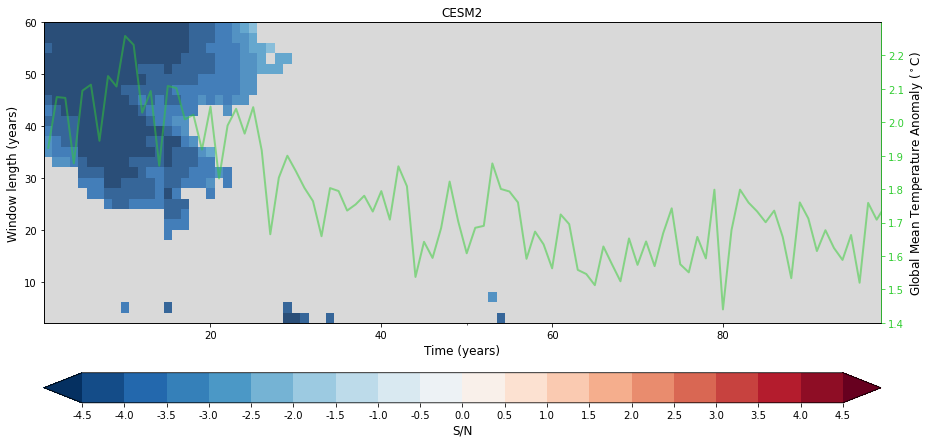

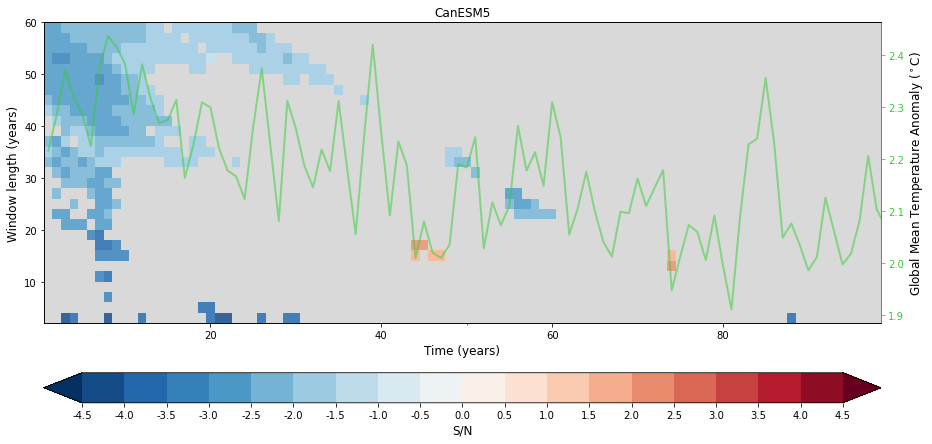

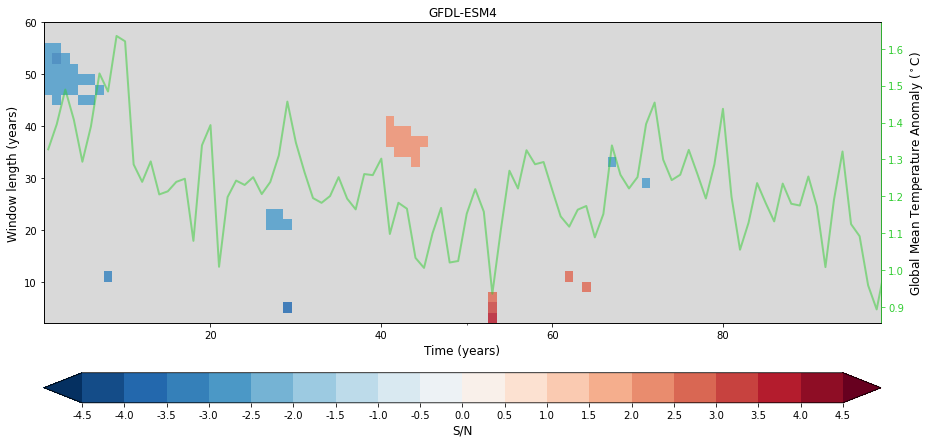

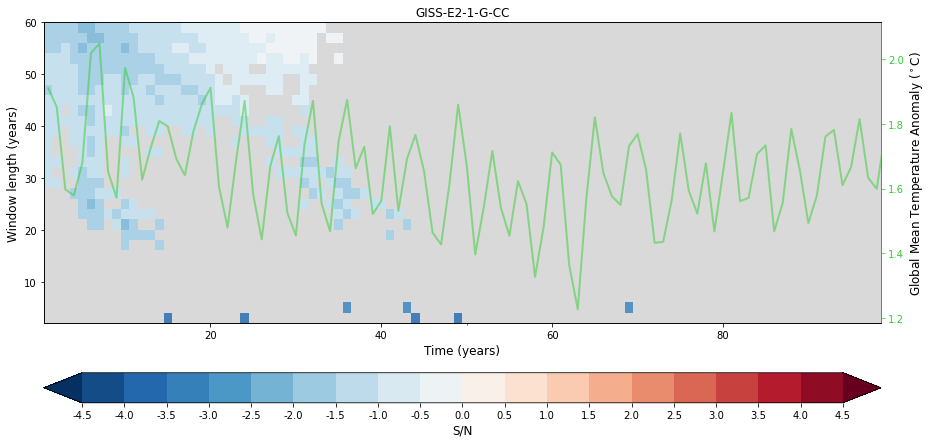

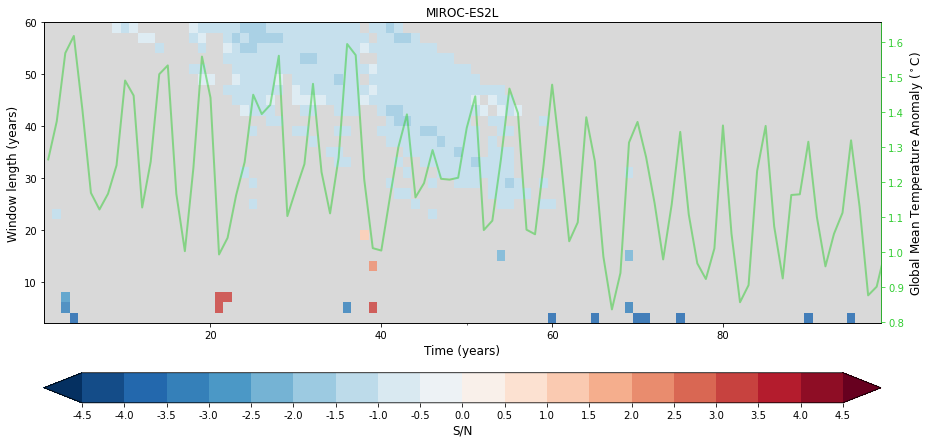

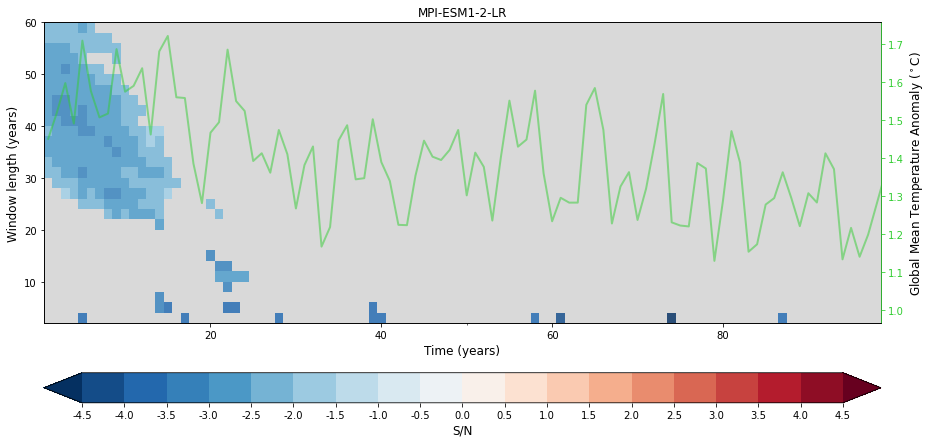

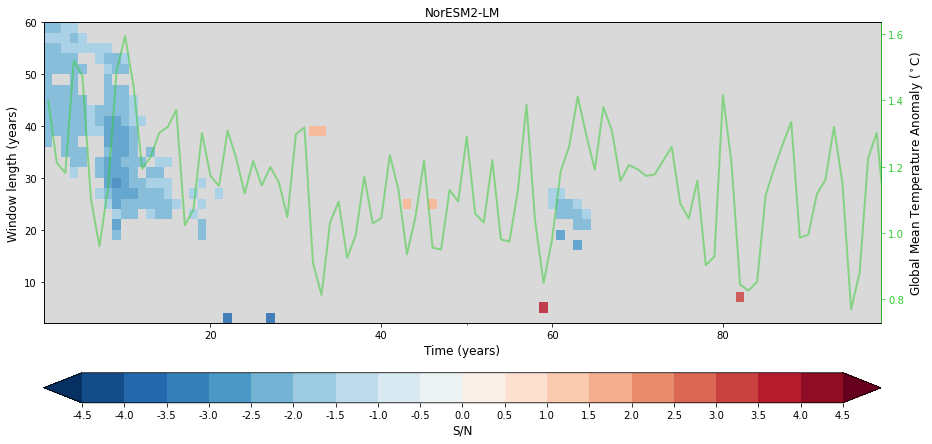

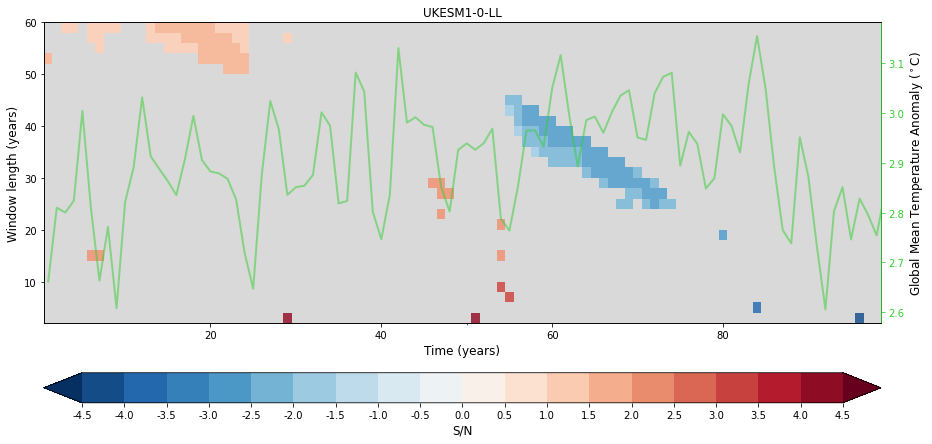

In [29]:
reload(sn_plotting)
mpl.rcParams.update(mpl.rcParamsDefault)

# Looping through all the models in our resultant dicionary and printing the result. 
for model in unstable_sn_da.model.values:
    print(model)
    (fig, ax1, ax2, ax3, cbar) = sn_plotting.sn_multi_window_in_time(
                            unstable_sn_da.sel(model=model)['signal_to_noise'], 
                            stable_sn_da.sel(model=model)['signal_to_noise'],
                            experiment_smean_ds.sel(model=model).dropna(dim='time'),
                                title=model, step=0.5, vmax=4.5, vmin=-4.5);
    
    save_name = f'{constants.IMAGE_SAVE_DIR_TOP_LEVEL}/zecmip_03_individual_models_{model}_SN_multi_window.png'
    print(f'Saving {save_name}')
    fig.savefig(save_name, dpi=400, bbox_inches='tight')

In [30]:
len(stable_sn_da.model.values)

8

{'height': 15, 'width': 12, 'hspace': 0.3, 'vmin': 0, 'vmax': 9, 'step': 1, 'cmap': <matplotlib.colors.LinearSegmentedColormap object at 0x7f69cc6f01c0>, 'line_color': 'limegreen', 'line_alpha': 0.5, 'cbar_label': 'Number of Unstable Models', 'cbartick_offset': 0.5, 'title': 'Fraction of ZECMIP Models with Decreasing GMST Trends', 'label_size': 12, 'extend': 'neither', 'xlowerlim': None, 'xupperlim': 100, 'hieght': 15, 'cbar_ncols': 5, 'filter_max': True, 'levels': array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), 'cbar_xticklabels': array([0, 1, 2, 3, 4, 5, 6, 7, 8]), 'cbar_ticks': array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5])}


locator: <matplotlib.ticker.FixedLocator object at 0x7f69cc586cd0>
cbar x-tick labels = [0 1 2 3 4 5 6 7 8]
['CESM2', 'CanESM5', 'GFDL-ESM4', 'GISS-E2-1-G-CC', 'MIROC-ES2L', 'MPI-ESM1-2-LR', 'NorESM2-LM', 'UKESM1-0-LL']
0 1 2 3 4 5 6 7 Saving /home/563/ab2313/gdata/images/PhD/top_level/zecmip_03_all_models_fraction_decrasing_unstable_SN_multi_window.png


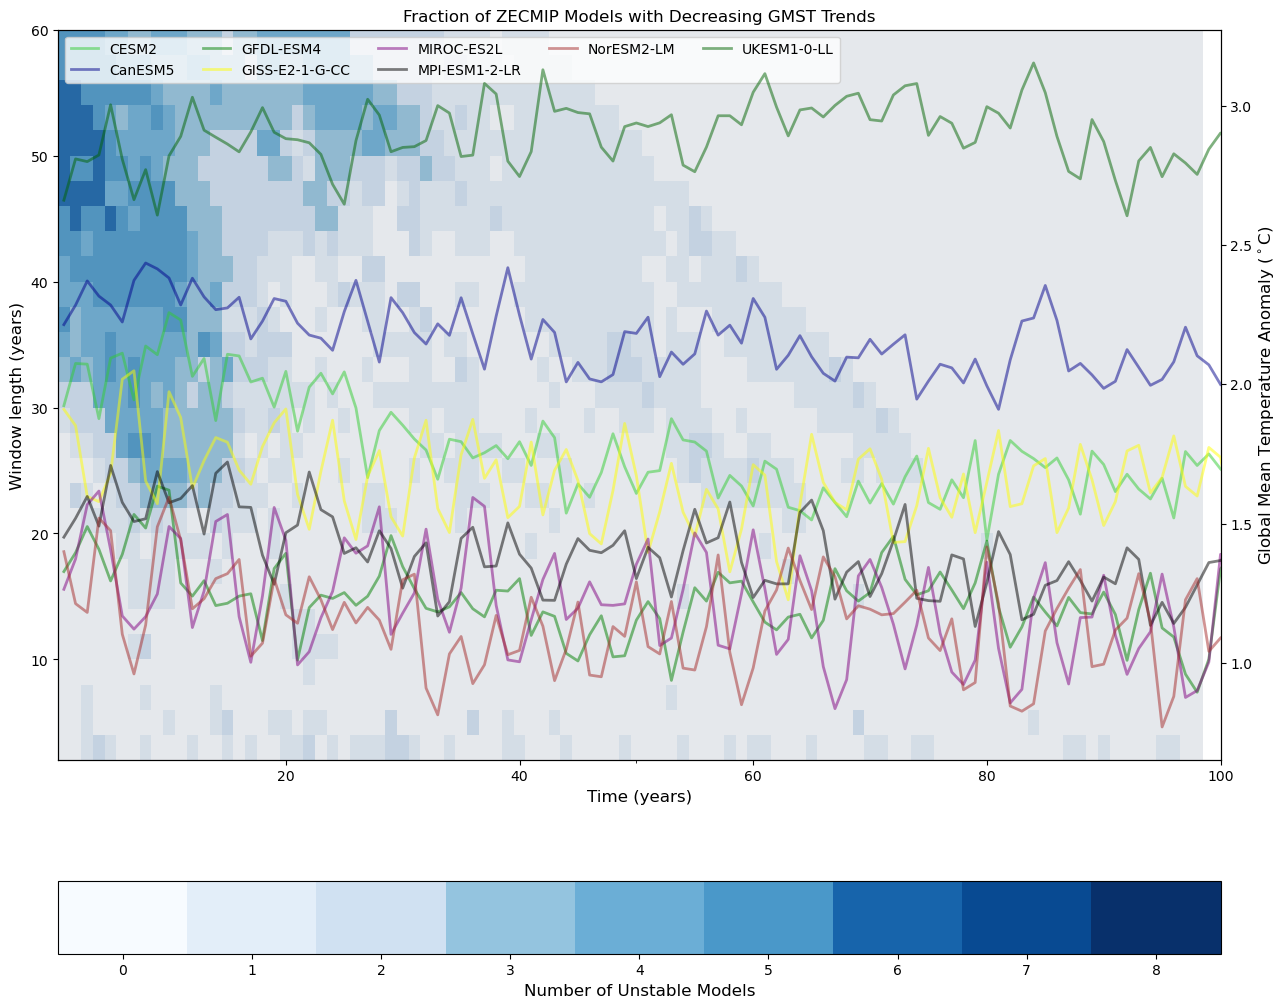

In [31]:
mpl.rcParams.update(mpl.rcParamsDefault)
fig, ax1, ax2, ax3,cbar = sn_plotting.sn_multi_window_in_time(
    unstable_decreaseing_sn_number.signal_to_noise,
    stable_sn_da.signal_to_noise.count(dim='model'), 
    experiment_smean_ds_dvar, 
    logginglevel='DEBUG', 
    hieght = 15, width = 12,
    vmin=0, vmax=9, step=1, cbartick_offset = 0.5,
    cmap='Blues',
    extend='neither', xupperlim = 100,
    cbar_label= 'Number of Unstable Models', 
    title = f'Fraction of ZECMIP Models with Decreasing GMST Trends', cbar_ncols = 5, filter_max=True)


save_name = f'{constants.IMAGE_SAVE_DIR_TOP_LEVEL}/zecmip_03_all_models_fraction_decrasing_unstable_SN_multi_window.png'
print(f'Saving {save_name}')
fig.savefig(save_name, dpi=400, bbox_inches='tight')

findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFourSymBol.ttf', name='STIXSizeFourSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/cmsy10.ttf', name='cmsy10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono.ttf', name='DejaVu Sans Mono', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3

findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono-BoldOblique.ttf', name='DejaVu Sans Mono', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-Italic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXNonUniIta.ttf', name='STIXNonUnicode', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fon

findfont: score(FontEntry(fname='/usr/share/fonts/dejavu/DejaVuSerif.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/gnu-free/FreeMonoBoldOblique.ttf', name='FreeMono', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-LightItalic.otf', name='Montserrat Alternates', style='italic', variant='normal', weight=300, stretch='normal', size='scalable')) = 11.145
findfont: score(FontEntry(fname='/usr/share/fonts/google-droid/DroidSansHebrew-Bold.ttf', name='Droid Sans Hebrew', style='normal', variant='normal', weight=600, stretch='normal', size='scalable')) = 10.24
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/fonts/UbuntuMono-RI.ttf', name='Ubuntu Mono', style='italic', variant='normal', weight=400, s

findfont: score(FontEntry(fname='/usr/share/fonts/dejavu/DejaVuSansCondensed-Oblique.ttf', name='DejaVu Sans', style='oblique', variant='normal', weight=400, stretch='condensed', size='scalable')) = 5.25
findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/Z003-MediumItalic.otf', name='Z003', style='italic', variant='normal', weight=500, stretch='normal', size='scalable')) = 11.145
findfont: score(FontEntry(fname='/usr/share/fonts/paratype-pt-sans/PTS56F.ttf', name='PT Sans', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-Regular.otf', name='Montserrat Alternates', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/google-noto-cjk/NotoSansCJK-Thin.ttc', name='Noto Sans CJK JP', style='normal', variant='normal', weight=100, stretch='normal', size='scalable')

findfont: score(FontEntry(fname='/usr/share/fonts/gnu-free/FreeSans.ttf', name='FreeSans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/fonts/Ubuntu-M.ttf', name='Ubuntu', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.145
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/Montserrat-ThinItalic.otf', name='Montserrat', style='italic', variant='normal', weight=250, stretch='normal', size='scalable')) = 11.1925
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-BoldItalic.otf', name='Montserrat Alternates', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/Montserrat-ExtraLight.otf', name='Montserrat', style='normal', variant='normal', weight=2

findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-MediumItalic.otf', name='Montserrat Alternates', style='italic', variant='normal', weight=500, stretch='normal', size='scalable')) = 11.145
findfont: score(FontEntry(fname='/usr/share/fonts/google-crosextra-carlito/Carlito-Italic.ttf', name='Carlito', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/usr/share/fonts/liberation-sans/LiberationSans-Italic.ttf', name='Liberation Sans', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 3.05
findfont: score(FontEntry(fname='/usr/share/fonts/gnu-free/FreeSerifBold.ttf', name='FreeSerif', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/usr/share/fonts/gnu-free/FreeSerifBoldItalic.ttf', name='FreeSerif', style='italic', variant='normal', weight=700, stretch='normal', siz

findfont: score(FontEntry(fname='/usr/share/fonts/liberation-sans/LiberationSans-BoldItalic.ttf', name='Liberation Sans', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 3.335
findfont: score(FontEntry(fname='/usr/share/fonts/liberation-mono/LiberationMono-Bold.ttf', name='Liberation Mono', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/usr/share/fonts/google-crosextra-caladea/Caladea-Regular.ttf', name='Caladea', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/fonts/SourceCodePro-LightIt.ttf', name='Source Code Pro', style='italic', variant='normal', weight=300, stretch='normal', size='scalable')) = 11.145
findfont: score(FontEntry(fname='/usr/share/fonts/lohit-gurmukhi/Lohit-Gurmukhi.ttf', name='Lohit Gurmukhi', style='normal', variant='normal

findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=15.0.
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFourSymBol.ttf', name='STIXSizeFourSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/cmsy10.ttf', name='cmsy10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono.ttf', name='DejaVu Sans Mono', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3

findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono-BoldOblique.ttf', name='DejaVu Sans Mono', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-Italic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXNonUniIta.ttf', name='STIXNonUnicode', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fon

findfont: score(FontEntry(fname='/usr/share/fonts/dejavu/DejaVuSerif.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/gnu-free/FreeMonoBoldOblique.ttf', name='FreeMono', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-LightItalic.otf', name='Montserrat Alternates', style='italic', variant='normal', weight=300, stretch='normal', size='scalable')) = 11.145
findfont: score(FontEntry(fname='/usr/share/fonts/google-droid/DroidSansHebrew-Bold.ttf', name='Droid Sans Hebrew', style='normal', variant='normal', weight=600, stretch='normal', size='scalable')) = 10.24
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/fonts/UbuntuMono-RI.ttf', name='Ubuntu Mono', style='italic', variant='normal', weight=400, s

findfont: score(FontEntry(fname='/usr/share/fonts/dejavu/DejaVuSansCondensed-Oblique.ttf', name='DejaVu Sans', style='oblique', variant='normal', weight=400, stretch='condensed', size='scalable')) = 5.25
findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/Z003-MediumItalic.otf', name='Z003', style='italic', variant='normal', weight=500, stretch='normal', size='scalable')) = 11.145
findfont: score(FontEntry(fname='/usr/share/fonts/paratype-pt-sans/PTS56F.ttf', name='PT Sans', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-Regular.otf', name='Montserrat Alternates', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/google-noto-cjk/NotoSansCJK-Thin.ttc', name='Noto Sans CJK JP', style='normal', variant='normal', weight=100, stretch='normal', size='scalable')

findfont: score(FontEntry(fname='/usr/share/fonts/gnu-free/FreeSans.ttf', name='FreeSans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/fonts/Ubuntu-M.ttf', name='Ubuntu', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.145
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/Montserrat-ThinItalic.otf', name='Montserrat', style='italic', variant='normal', weight=250, stretch='normal', size='scalable')) = 11.1925
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-BoldItalic.otf', name='Montserrat Alternates', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/Montserrat-ExtraLight.otf', name='Montserrat', style='normal', variant='normal', weight=2

findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-MediumItalic.otf', name='Montserrat Alternates', style='italic', variant='normal', weight=500, stretch='normal', size='scalable')) = 11.145
findfont: score(FontEntry(fname='/usr/share/fonts/google-crosextra-carlito/Carlito-Italic.ttf', name='Carlito', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/usr/share/fonts/liberation-sans/LiberationSans-Italic.ttf', name='Liberation Sans', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 3.05
findfont: score(FontEntry(fname='/usr/share/fonts/gnu-free/FreeSerifBold.ttf', name='FreeSerif', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/usr/share/fonts/gnu-free/FreeSerifBoldItalic.ttf', name='FreeSerif', style='italic', variant='normal', weight=700, stretch='normal', siz

findfont: score(FontEntry(fname='/usr/share/fonts/liberation-sans/LiberationSans-BoldItalic.ttf', name='Liberation Sans', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 3.335
findfont: score(FontEntry(fname='/usr/share/fonts/liberation-mono/LiberationMono-Bold.ttf', name='Liberation Mono', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/usr/share/fonts/google-crosextra-caladea/Caladea-Regular.ttf', name='Caladea', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/fonts/SourceCodePro-LightIt.ttf', name='Source Code Pro', style='italic', variant='normal', weight=300, stretch='normal', size='scalable')) = 11.145
findfont: score(FontEntry(fname='/usr/share/fonts/lohit-gurmukhi/Lohit-Gurmukhi.ttf', name='Lohit Gurmukhi', style='normal', variant='normal

findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=14.0.
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFourSymBol.ttf', name='STIXSizeFourSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/cmsy10.ttf', name='cmsy10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono.ttf', name='DejaVu Sans Mono', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3

findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono-BoldOblique.ttf', name='DejaVu Sans Mono', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-Italic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXNonUniIta.ttf', name='STIXNonUnicode', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fon

findfont: score(FontEntry(fname='/usr/share/fonts/dejavu/DejaVuSerif.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/gnu-free/FreeMonoBoldOblique.ttf', name='FreeMono', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-LightItalic.otf', name='Montserrat Alternates', style='italic', variant='normal', weight=300, stretch='normal', size='scalable')) = 11.145
findfont: score(FontEntry(fname='/usr/share/fonts/google-droid/DroidSansHebrew-Bold.ttf', name='Droid Sans Hebrew', style='normal', variant='normal', weight=600, stretch='normal', size='scalable')) = 10.24
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/fonts/UbuntuMono-RI.ttf', name='Ubuntu Mono', style='italic', variant='normal', weight=400, s

findfont: score(FontEntry(fname='/usr/share/fonts/dejavu/DejaVuSansCondensed-Oblique.ttf', name='DejaVu Sans', style='oblique', variant='normal', weight=400, stretch='condensed', size='scalable')) = 5.25
findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/Z003-MediumItalic.otf', name='Z003', style='italic', variant='normal', weight=500, stretch='normal', size='scalable')) = 11.145
findfont: score(FontEntry(fname='/usr/share/fonts/paratype-pt-sans/PTS56F.ttf', name='PT Sans', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-Regular.otf', name='Montserrat Alternates', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/google-noto-cjk/NotoSansCJK-Thin.ttc', name='Noto Sans CJK JP', style='normal', variant='normal', weight=100, stretch='normal', size='scalable')

findfont: score(FontEntry(fname='/usr/share/fonts/gnu-free/FreeSans.ttf', name='FreeSans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/fonts/Ubuntu-M.ttf', name='Ubuntu', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.145
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/Montserrat-ThinItalic.otf', name='Montserrat', style='italic', variant='normal', weight=250, stretch='normal', size='scalable')) = 11.1925
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-BoldItalic.otf', name='Montserrat Alternates', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/Montserrat-ExtraLight.otf', name='Montserrat', style='normal', variant='normal', weight=2

findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-MediumItalic.otf', name='Montserrat Alternates', style='italic', variant='normal', weight=500, stretch='normal', size='scalable')) = 11.145
findfont: score(FontEntry(fname='/usr/share/fonts/google-crosextra-carlito/Carlito-Italic.ttf', name='Carlito', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/usr/share/fonts/liberation-sans/LiberationSans-Italic.ttf', name='Liberation Sans', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 3.05
findfont: score(FontEntry(fname='/usr/share/fonts/gnu-free/FreeSerifBold.ttf', name='FreeSerif', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/usr/share/fonts/gnu-free/FreeSerifBoldItalic.ttf', name='FreeSerif', style='italic', variant='normal', weight=700, stretch='normal', siz

findfont: score(FontEntry(fname='/usr/share/fonts/liberation-sans/LiberationSans-BoldItalic.ttf', name='Liberation Sans', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 3.335
findfont: score(FontEntry(fname='/usr/share/fonts/liberation-mono/LiberationMono-Bold.ttf', name='Liberation Mono', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/usr/share/fonts/google-crosextra-caladea/Caladea-Regular.ttf', name='Caladea', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/fonts/SourceCodePro-LightIt.ttf', name='Source Code Pro', style='italic', variant='normal', weight=300, stretch='normal', size='scalable')) = 11.145
findfont: score(FontEntry(fname='/usr/share/fonts/lohit-gurmukhi/Lohit-Gurmukhi.ttf', name='Lohit Gurmukhi', style='normal', variant='normal

findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=16.0.
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFourSymBol.ttf', name='STIXSizeFourSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/cmsy10.ttf', name='cmsy10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono.ttf', name='DejaVu Sans Mono', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3

findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono-BoldOblique.ttf', name='DejaVu Sans Mono', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-Italic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXNonUniIta.ttf', name='STIXNonUnicode', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fon

findfont: score(FontEntry(fname='/usr/share/fonts/dejavu/DejaVuSerif.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/gnu-free/FreeMonoBoldOblique.ttf', name='FreeMono', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-LightItalic.otf', name='Montserrat Alternates', style='italic', variant='normal', weight=300, stretch='normal', size='scalable')) = 11.145
findfont: score(FontEntry(fname='/usr/share/fonts/google-droid/DroidSansHebrew-Bold.ttf', name='Droid Sans Hebrew', style='normal', variant='normal', weight=600, stretch='normal', size='scalable')) = 10.24
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/fonts/UbuntuMono-RI.ttf', name='Ubuntu Mono', style='italic', variant='normal', weight=400, s

findfont: score(FontEntry(fname='/usr/share/fonts/dejavu/DejaVuSansCondensed-Oblique.ttf', name='DejaVu Sans', style='oblique', variant='normal', weight=400, stretch='condensed', size='scalable')) = 5.25
findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/Z003-MediumItalic.otf', name='Z003', style='italic', variant='normal', weight=500, stretch='normal', size='scalable')) = 11.145
findfont: score(FontEntry(fname='/usr/share/fonts/paratype-pt-sans/PTS56F.ttf', name='PT Sans', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-Regular.otf', name='Montserrat Alternates', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/google-noto-cjk/NotoSansCJK-Thin.ttc', name='Noto Sans CJK JP', style='normal', variant='normal', weight=100, stretch='normal', size='scalable')

findfont: score(FontEntry(fname='/usr/share/fonts/gnu-free/FreeSans.ttf', name='FreeSans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/fonts/Ubuntu-M.ttf', name='Ubuntu', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.145
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/Montserrat-ThinItalic.otf', name='Montserrat', style='italic', variant='normal', weight=250, stretch='normal', size='scalable')) = 11.1925
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-BoldItalic.otf', name='Montserrat Alternates', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/Montserrat-ExtraLight.otf', name='Montserrat', style='normal', variant='normal', weight=2

findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-MediumItalic.otf', name='Montserrat Alternates', style='italic', variant='normal', weight=500, stretch='normal', size='scalable')) = 11.145
findfont: score(FontEntry(fname='/usr/share/fonts/google-crosextra-carlito/Carlito-Italic.ttf', name='Carlito', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/usr/share/fonts/liberation-sans/LiberationSans-Italic.ttf', name='Liberation Sans', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 3.05
findfont: score(FontEntry(fname='/usr/share/fonts/gnu-free/FreeSerifBold.ttf', name='FreeSerif', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/usr/share/fonts/gnu-free/FreeSerifBoldItalic.ttf', name='FreeSerif', style='italic', variant='normal', weight=700, stretch='normal', siz

findfont: score(FontEntry(fname='/usr/share/fonts/liberation-sans/LiberationSans-BoldItalic.ttf', name='Liberation Sans', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 3.335
findfont: score(FontEntry(fname='/usr/share/fonts/liberation-mono/LiberationMono-Bold.ttf', name='Liberation Mono', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/usr/share/fonts/google-crosextra-caladea/Caladea-Regular.ttf', name='Caladea', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/fonts/SourceCodePro-LightIt.ttf', name='Source Code Pro', style='italic', variant='normal', weight=300, stretch='normal', size='scalable')) = 11.145
findfont: score(FontEntry(fname='/usr/share/fonts/lohit-gurmukhi/Lohit-Gurmukhi.ttf', name='Lohit Gurmukhi', style='normal', variant='normal

findfont: Matching STIXGeneral:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFourSymBol.ttf', name='STIXSizeFourSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/cmsy10.ttf', name='cmsy10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono.ttf', name='DejaVu Sans Mono', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3

findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono-BoldOblique.ttf', name='DejaVu Sans Mono', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-Italic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXNonUniIta.ttf', name='STIXNonUnicode', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fon

findfont: score(FontEntry(fname='/usr/share/fonts/dejavu/DejaVuSerif.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/gnu-free/FreeMonoBoldOblique.ttf', name='FreeMono', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-LightItalic.otf', name='Montserrat Alternates', style='italic', variant='normal', weight=300, stretch='normal', size='scalable')) = 11.145
findfont: score(FontEntry(fname='/usr/share/fonts/google-droid/DroidSansHebrew-Bold.ttf', name='Droid Sans Hebrew', style='normal', variant='normal', weight=600, stretch='normal', size='scalable')) = 10.24
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/fonts/UbuntuMono-RI.ttf', name='Ubuntu Mono', style='italic', variant='normal', weight=400, s

findfont: score(FontEntry(fname='/usr/share/fonts/dejavu/DejaVuSansCondensed-Oblique.ttf', name='DejaVu Sans', style='oblique', variant='normal', weight=400, stretch='condensed', size='scalable')) = 11.25
findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/Z003-MediumItalic.otf', name='Z003', style='italic', variant='normal', weight=500, stretch='normal', size='scalable')) = 11.145
findfont: score(FontEntry(fname='/usr/share/fonts/paratype-pt-sans/PTS56F.ttf', name='PT Sans', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-Regular.otf', name='Montserrat Alternates', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/google-noto-cjk/NotoSansCJK-Thin.ttc', name='Noto Sans CJK JP', style='normal', variant='normal', weight=100, stretch='normal', size='scalable'

findfont: score(FontEntry(fname='/usr/share/fonts/gnu-free/FreeSans.ttf', name='FreeSans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/fonts/Ubuntu-M.ttf', name='Ubuntu', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.145
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/Montserrat-ThinItalic.otf', name='Montserrat', style='italic', variant='normal', weight=250, stretch='normal', size='scalable')) = 11.1925
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-BoldItalic.otf', name='Montserrat Alternates', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/Montserrat-ExtraLight.otf', name='Montserrat', style='normal', variant='normal', weight=2

findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-MediumItalic.otf', name='Montserrat Alternates', style='italic', variant='normal', weight=500, stretch='normal', size='scalable')) = 11.145
findfont: score(FontEntry(fname='/usr/share/fonts/google-crosextra-carlito/Carlito-Italic.ttf', name='Carlito', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/usr/share/fonts/liberation-sans/LiberationSans-Italic.ttf', name='Liberation Sans', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/usr/share/fonts/gnu-free/FreeSerifBold.ttf', name='FreeSerif', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/usr/share/fonts/gnu-free/FreeSerifBoldItalic.ttf', name='FreeSerif', style='italic', variant='normal', weight=700, stretch='normal', si

findfont: score(FontEntry(fname='/usr/share/fonts/liberation-sans/LiberationSans-BoldItalic.ttf', name='Liberation Sans', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
findfont: score(FontEntry(fname='/usr/share/fonts/liberation-mono/LiberationMono-Bold.ttf', name='Liberation Mono', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/usr/share/fonts/google-crosextra-caladea/Caladea-Regular.ttf', name='Caladea', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/fonts/SourceCodePro-LightIt.ttf', name='Source Code Pro', style='italic', variant='normal', weight=300, stretch='normal', size='scalable')) = 11.145
findfont: score(FontEntry(fname='/usr/share/fonts/lohit-gurmukhi/Lohit-Gurmukhi.ttf', name='Lohit Gurmukhi', style='normal', variant='norma

findfont: Matching STIXGeneral:style=italic:variant=normal:weight=normal:stretch=normal:size=10.0.
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFourSymBol.ttf', name='STIXSizeFourSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/cmsy10.ttf', name='cmsy10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono.ttf', name='DejaVu Sans Mono', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3

findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono-BoldOblique.ttf', name='DejaVu Sans Mono', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.434999999999999
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-Italic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXNonUniIta.ttf', name='STIXNonUnicode', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/

findfont: score(FontEntry(fname='/usr/share/fonts/dejavu/DejaVuSerif.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/usr/share/fonts/gnu-free/FreeMonoBoldOblique.ttf', name='FreeMono', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.434999999999999
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-LightItalic.otf', name='Montserrat Alternates', style='italic', variant='normal', weight=300, stretch='normal', size='scalable')) = 10.145
findfont: score(FontEntry(fname='/usr/share/fonts/google-droid/DroidSansHebrew-Bold.ttf', name='Droid Sans Hebrew', style='normal', variant='normal', weight=600, stretch='normal', size='scalable')) = 11.24
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/fonts/UbuntuMono-RI.ttf', name='Ubuntu Mono', style='italic', variant='normal', w

findfont: score(FontEntry(fname='/usr/share/fonts/dejavu/DejaVuSansCondensed-Oblique.ttf', name='DejaVu Sans', style='oblique', variant='normal', weight=400, stretch='condensed', size='scalable')) = 10.35
findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/Z003-MediumItalic.otf', name='Z003', style='italic', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.145
findfont: score(FontEntry(fname='/usr/share/fonts/paratype-pt-sans/PTS56F.ttf', name='PT Sans', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-Regular.otf', name='Montserrat Alternates', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/usr/share/fonts/google-noto-cjk/NotoSansCJK-Thin.ttc', name='Noto Sans CJK JP', style='normal', variant='normal', weight=100, stretch='normal', size='scalable'

findfont: score(FontEntry(fname='/usr/share/fonts/gnu-free/FreeSans.ttf', name='FreeSans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/fonts/Ubuntu-M.ttf', name='Ubuntu', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 11.145
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/Montserrat-ThinItalic.otf', name='Montserrat', style='italic', variant='normal', weight=250, stretch='normal', size='scalable')) = 10.1925
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-BoldItalic.otf', name='Montserrat Alternates', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/Montserrat-ExtraLight.otf', name='Montserrat', style='normal', variant='normal', weight=2

findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-MediumItalic.otf', name='Montserrat Alternates', style='italic', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.145
findfont: score(FontEntry(fname='/usr/share/fonts/google-crosextra-carlito/Carlito-Italic.ttf', name='Carlito', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/liberation-sans/LiberationSans-Italic.ttf', name='Liberation Sans', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/gnu-free/FreeSerifBold.ttf', name='FreeSerif', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
findfont: score(FontEntry(fname='/usr/share/fonts/gnu-free/FreeSerifBoldItalic.ttf', name='FreeSerif', style='italic', variant='normal', weight=700, stretch='normal', si

findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/NimbusMonoPS-Italic.otf', name='Nimbus Mono PS', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/liberation-sans/LiberationSans-BoldItalic.ttf', name='Liberation Sans', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/usr/share/fonts/liberation-mono/LiberationMono-Bold.ttf', name='Liberation Mono', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
findfont: score(FontEntry(fname='/usr/share/fonts/google-crosextra-caladea/Caladea-Regular.ttf', name='Caladea', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/fonts/SourceCodePro-LightIt.ttf', name='Source Code Pro', style='italic', variant='norma

findfont: Matching STIXGeneral:style=italic:variant=normal:weight=normal:stretch=normal:size=10.0 to STIXGeneral ('/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralItalic.ttf') with score of 0.050000.
findfont: Matching STIXGeneral:style=normal:variant=normal:weight=bold:stretch=normal:size=10.0.
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFourSymBol.ttf', name='STIXSizeFourSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/cmsy10.ttf', name='cmsy10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/an

findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFourSymReg.ttf', name='STIXSizeFourSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono-BoldOblique.ttf', name='DejaVu Sans Mono', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-Italic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.335
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-da

findfont: score(FontEntry(fname='/usr/share/fonts/google-noto-cjk/NotoSerifCJK-SemiBold.ttc', name='Noto Serif CJK JP', style='normal', variant='normal', weight=600, stretch='normal', size='scalable')) = 10.145
findfont: score(FontEntry(fname='/usr/share/fonts/dejavu/DejaVuSerif.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/usr/share/fonts/gnu-free/FreeMonoBoldOblique.ttf', name='FreeMono', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-LightItalic.otf', name='Montserrat Alternates', style='italic', variant='normal', weight=300, stretch='normal', size='scalable')) = 11.43
findfont: score(FontEntry(fname='/usr/share/fonts/google-droid/DroidSansHebrew-Bold.ttf', name='Droid Sans Hebrew', style='normal', variant='normal', weight=600, stretch='normal'

findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-Bold.otf', name='Montserrat Alternates', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/dejavu/DejaVuSansCondensed-Oblique.ttf', name='DejaVu Sans', style='oblique', variant='normal', weight=400, stretch='condensed', size='scalable')) = 11.535
findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/Z003-MediumItalic.otf', name='Z003', style='italic', variant='normal', weight=500, stretch='normal', size='scalable')) = 11.24
findfont: score(FontEntry(fname='/usr/share/fonts/paratype-pt-sans/PTS56F.ttf', name='PT Sans', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.335
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-Regular.otf', name='Montserrat Alternates', style='normal', variant='normal', weight=400, stretch='nor

findfont: score(FontEntry(fname='/usr/share/fonts/google-droid/DroidSansFallback.ttf', name='Droid Sans Fallback', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/usr/share/fonts/gnu-free/FreeSans.ttf', name='FreeSans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/fonts/Ubuntu-M.ttf', name='Ubuntu', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.24
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/Montserrat-ThinItalic.otf', name='Montserrat', style='italic', variant='normal', weight=250, stretch='normal', size='scalable')) = 11.4775
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-BoldItalic.otf', name='Montserrat Alternates', style='italic', variant='normal', weight=700, 

findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/NimbusSans-Italic.otf', name='Nimbus Sans', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.335
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-MediumItalic.otf', name='Montserrat Alternates', style='italic', variant='normal', weight=500, stretch='normal', size='scalable')) = 11.24
findfont: score(FontEntry(fname='/usr/share/fonts/google-crosextra-carlito/Carlito-Italic.ttf', name='Carlito', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.335
findfont: score(FontEntry(fname='/usr/share/fonts/liberation-sans/LiberationSans-Italic.ttf', name='Liberation Sans', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.335
findfont: score(FontEntry(fname='/usr/share/fonts/gnu-free/FreeSerifBold.ttf', name='FreeSerif', style='normal', variant='normal', weight=700, stretch='normal',

findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/NimbusMonoPS-Italic.otf', name='Nimbus Mono PS', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.335
findfont: score(FontEntry(fname='/usr/share/fonts/liberation-sans/LiberationSans-BoldItalic.ttf', name='Liberation Sans', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/usr/share/fonts/liberation-mono/LiberationMono-Bold.ttf', name='Liberation Mono', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/google-crosextra-caladea/Caladea-Regular.ttf', name='Caladea', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/fonts/SourceCodePro-LightIt.ttf', name='Source Code Pro', style='italic', variant='norma

findfont: Matching STIXGeneral:style=normal:variant=normal:weight=bold:stretch=normal:size=10.0 to STIXGeneral ('/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralBol.ttf') with score of 0.050000.
findfont: Matching STIXNonUnicode:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFourSymBol.ttf', name='STIXSizeFourSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/cmsy10.ttf', name='cmsy10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/an

findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFourSymReg.ttf', name='STIXSizeFourSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono-BoldOblique.ttf', name='DejaVu Sans Mono', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-Italic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-dat

findfont: score(FontEntry(fname='/usr/share/fonts/google-noto-cjk/NotoSerifCJK-SemiBold.ttc', name='Noto Serif CJK JP', style='normal', variant='normal', weight=600, stretch='normal', size='scalable')) = 10.24
findfont: score(FontEntry(fname='/usr/share/fonts/dejavu/DejaVuSerif.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/gnu-free/FreeMonoBoldOblique.ttf', name='FreeMono', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-LightItalic.otf', name='Montserrat Alternates', style='italic', variant='normal', weight=300, stretch='normal', size='scalable')) = 11.145
findfont: score(FontEntry(fname='/usr/share/fonts/google-droid/DroidSansHebrew-Bold.ttf', name='Droid Sans Hebrew', style='normal', variant='normal', weight=600, stretch='normal'

findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-Bold.otf', name='Montserrat Alternates', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/usr/share/fonts/dejavu/DejaVuSansCondensed-Oblique.ttf', name='DejaVu Sans', style='oblique', variant='normal', weight=400, stretch='condensed', size='scalable')) = 11.25
findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/Z003-MediumItalic.otf', name='Z003', style='italic', variant='normal', weight=500, stretch='normal', size='scalable')) = 11.145
findfont: score(FontEntry(fname='/usr/share/fonts/paratype-pt-sans/PTS56F.ttf', name='PT Sans', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-Regular.otf', name='Montserrat Alternates', style='normal', variant='normal', weight=400, stretch='nor

findfont: score(FontEntry(fname='/usr/share/fonts/google-droid/DroidSansFallback.ttf', name='Droid Sans Fallback', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/gnu-free/FreeSans.ttf', name='FreeSans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/fonts/Ubuntu-M.ttf', name='Ubuntu', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.145
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/Montserrat-ThinItalic.otf', name='Montserrat', style='italic', variant='normal', weight=250, stretch='normal', size='scalable')) = 11.1925
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-BoldItalic.otf', name='Montserrat Alternates', style='italic', variant='normal', weight=700, s

findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/NimbusSans-Italic.otf', name='Nimbus Sans', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-MediumItalic.otf', name='Montserrat Alternates', style='italic', variant='normal', weight=500, stretch='normal', size='scalable')) = 11.145
findfont: score(FontEntry(fname='/usr/share/fonts/google-crosextra-carlito/Carlito-Italic.ttf', name='Carlito', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/usr/share/fonts/liberation-sans/LiberationSans-Italic.ttf', name='Liberation Sans', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/usr/share/fonts/gnu-free/FreeSerifBold.ttf', name='FreeSerif', style='normal', variant='normal', weight=700, stretch='normal', s

findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/NimbusMonoPS-Italic.otf', name='Nimbus Mono PS', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/usr/share/fonts/liberation-sans/LiberationSans-BoldItalic.ttf', name='Liberation Sans', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
findfont: score(FontEntry(fname='/usr/share/fonts/liberation-mono/LiberationMono-Bold.ttf', name='Liberation Mono', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/usr/share/fonts/google-crosextra-caladea/Caladea-Regular.ttf', name='Caladea', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/fonts/SourceCodePro-LightIt.ttf', name='Source Code Pro', style='italic', variant='norma

findfont: Matching STIXNonUnicode:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to STIXNonUnicode ('/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXNonUni.ttf') with score of 0.050000.
findfont: Matching STIXNonUnicode:style=italic:variant=normal:weight=normal:stretch=normal:size=10.0.
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFourSymBol.ttf', name='STIXSizeFourSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/cmsy10.ttf', name='cmsy10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/env

findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFourSymReg.ttf', name='STIXSizeFourSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono-BoldOblique.ttf', name='DejaVu Sans Mono', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.434999999999999
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-Italic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplo

findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/fonts/SourceCodePro-Black.ttf', name='Source Code Pro', style='normal', variant='normal', weight=900, stretch='normal', size='scalable')) = 11.525
findfont: score(FontEntry(fname='/usr/share/fonts/google-noto-cjk/NotoSerifCJK-SemiBold.ttc', name='Noto Serif CJK JP', style='normal', variant='normal', weight=600, stretch='normal', size='scalable')) = 11.24
findfont: score(FontEntry(fname='/usr/share/fonts/dejavu/DejaVuSerif.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/usr/share/fonts/gnu-free/FreeMonoBoldOblique.ttf', name='FreeMono', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.434999999999999
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-LightItalic.otf', name='Montserrat Alternates', style='italic', varia

findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/NimbusSans-Regular.otf', name='Nimbus Sans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-Bold.otf', name='Montserrat Alternates', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
findfont: score(FontEntry(fname='/usr/share/fonts/dejavu/DejaVuSansCondensed-Oblique.ttf', name='DejaVu Sans', style='oblique', variant='normal', weight=400, stretch='condensed', size='scalable')) = 10.35
findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/Z003-MediumItalic.otf', name='Z003', style='italic', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.145
findfont: score(FontEntry(fname='/usr/share/fonts/paratype-pt-sans/PTS56F.ttf', name='PT Sans', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05

findfont: score(FontEntry(fname='/usr/share/fonts/google-noto/NotoSansMeeteiMayek-Regular.ttf', name='Noto Sans Meetei Mayek', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/usr/share/fonts/google-droid/DroidSansFallback.ttf', name='Droid Sans Fallback', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/usr/share/fonts/gnu-free/FreeSans.ttf', name='FreeSans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/fonts/Ubuntu-M.ttf', name='Ubuntu', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 11.145
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/Montserrat-ThinItalic.otf', name='Montserrat', style='italic', variant='normal', weight=250, stretch='normal'

findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/fonts/SourceCodePro-Light.ttf', name='Source Code Pro', style='normal', variant='normal', weight=300, stretch='normal', size='scalable')) = 11.145
findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/NimbusSans-Italic.otf', name='Nimbus Sans', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-MediumItalic.otf', name='Montserrat Alternates', style='italic', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.145
findfont: score(FontEntry(fname='/usr/share/fonts/google-crosextra-carlito/Carlito-Italic.ttf', name='Carlito', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/liberation-sans/LiberationSans-Italic.ttf', name='Liberation Sans', style='italic', 

findfont: score(FontEntry(fname='/usr/share/fonts/thai-scalable/Waree.ttf', name='Waree', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-Black.otf', name='Montserrat Alternates', style='normal', variant='normal', weight=900, stretch='normal', size='scalable')) = 11.525
findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/NimbusMonoPS-Italic.otf', name='Nimbus Mono PS', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/liberation-sans/LiberationSans-BoldItalic.ttf', name='Liberation Sans', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/usr/share/fonts/liberation-mono/LiberationMono-Bold.ttf', name='Liberation Mono', style='normal', variant='normal', weight=700, stretch='normal', s

findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/P052-Bold.otf', name='P052', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/NimbusRoman-Bold.otf', name='Nimbus Roman', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
findfont: Matching STIXNonUnicode:style=italic:variant=normal:weight=normal:stretch=normal:size=10.0 to STIXNonUnicode ('/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXNonUniIta.ttf') with score of 0.050000.
findfont: Matching STIXNonUnicode:style=normal:variant=normal:weight=bold:stretch=normal:size=10.0.
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFourSymBol.ttf', name='STIXSizeFourSym', style='normal', variant='normal', weight=700, str

findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFiveSymReg.ttf', name='STIXSizeFiveSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFourSymReg.ttf', name='STIXSizeFourSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono-BoldOblique.ttf', name='DejaVu Sans Mono', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-

findfont: score(FontEntry(fname='/usr/share/fonts/paratype-pt-sans/PTS55F.ttf', name='PT Sans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/fonts/SourceCodePro-Black.ttf', name='Source Code Pro', style='normal', variant='normal', weight=900, stretch='normal', size='scalable')) = 10.24
findfont: score(FontEntry(fname='/usr/share/fonts/google-noto-cjk/NotoSerifCJK-SemiBold.ttc', name='Noto Serif CJK JP', style='normal', variant='normal', weight=600, stretch='normal', size='scalable')) = 10.145
findfont: score(FontEntry(fname='/usr/share/fonts/dejavu/DejaVuSerif.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/usr/share/fonts/gnu-free/FreeMonoBoldOblique.ttf', name='FreeMono', style='oblique', variant='normal', weight=700, stretch='normal', size='scalabl

findfont: score(FontEntry(fname='/usr/share/fonts/google-droid/DroidSansEthiopic-Bold.ttf', name='Droid Sans Ethiopic', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/NimbusSans-Regular.otf', name='Nimbus Sans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-Bold.otf', name='Montserrat Alternates', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/dejavu/DejaVuSansCondensed-Oblique.ttf', name='DejaVu Sans', style='oblique', variant='normal', weight=400, stretch='condensed', size='scalable')) = 11.535
findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/Z003-MediumItalic.otf', name='Z003', style='italic', variant='normal', weight=500, stretch='normal', s

findfont: score(FontEntry(fname='/usr/share/fonts/gnu-free/FreeMonoBold.ttf', name='FreeMono', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/abattis-cantarell/Cantarell-Bold.otf', name='Cantarell', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/google-noto/NotoSansMeeteiMayek-Regular.ttf', name='Noto Sans Meetei Mayek', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/usr/share/fonts/google-droid/DroidSansFallback.ttf', name='Droid Sans Fallback', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/usr/share/fonts/gnu-free/FreeSans.ttf', name='FreeSans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
findfont: sc

findfont: score(FontEntry(fname='/usr/share/fonts/google-droid/DroidSansJapanese.ttf', name='Droid Sans Japanese', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/Montserrat-LightItalic.otf', name='Montserrat', style='italic', variant='normal', weight=300, stretch='normal', size='scalable')) = 11.43
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/fonts/SourceCodePro-Light.ttf', name='Source Code Pro', style='normal', variant='normal', weight=300, stretch='normal', size='scalable')) = 10.43
findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/NimbusSans-Italic.otf', name='Nimbus Sans', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.335
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-MediumItalic.otf', name='Montserrat Alternates', style='ital

findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-ExtraBoldItalic.otf', name='Montserrat Alternates', style='italic', variant='normal', weight=800, stretch='normal', size='scalable')) = 11.145
findfont: score(FontEntry(fname='/usr/share/fonts/thai-scalable/Waree.ttf', name='Waree', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-Black.otf', name='Montserrat Alternates', style='normal', variant='normal', weight=900, stretch='normal', size='scalable')) = 10.24
findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/NimbusMonoPS-Italic.otf', name='Nimbus Mono PS', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.335
findfont: score(FontEntry(fname='/usr/share/fonts/liberation-sans/LiberationSans-BoldItalic.ttf', name='Liberation Sans', style='italic', variant='normal', w

findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-Italic.otf', name='Montserrat Alternates', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.335
findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/P052-Bold.otf', name='P052', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/NimbusRoman-Bold.otf', name='Nimbus Roman', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.05
findfont: Matching STIXNonUnicode:style=normal:variant=normal:weight=bold:stretch=normal:size=10.0 to STIXNonUnicode ('/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXNonUniBol.ttf') with score of 0.050000.
findfont: Matching STIXSizeOneSym:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
findfont: score(Fon

findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneral.ttf', name='STIXGeneral', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFiveSymReg.ttf', name='STIXSizeFiveSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFourSymReg.ttf', name='STIXSizeFourSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSa

findfont: score(FontEntry(fname='/usr/share/fonts/google-noto/NotoSansTagalog-Regular.ttf', name='Noto Sans Tagalog', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/paratype-pt-sans/PTS55F.ttf', name='PT Sans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/fonts/SourceCodePro-Black.ttf', name='Source Code Pro', style='normal', variant='normal', weight=900, stretch='normal', size='scalable')) = 10.525
findfont: score(FontEntry(fname='/usr/share/fonts/google-noto-cjk/NotoSerifCJK-SemiBold.ttc', name='Noto Serif CJK JP', style='normal', variant='normal', weight=600, stretch='normal', size='scalable')) = 10.24
findfont: score(FontEntry(fname='/usr/share/fonts/dejavu/DejaVuSerif.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=400, stretch='normal', 

findfont: score(FontEntry(fname='/usr/share/fonts/khmeros/KhmerOS_content.ttf', name='Khmer OS Content', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/google-droid/DroidSansEthiopic-Bold.ttf', name='Droid Sans Ethiopic', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/NimbusSans-Regular.otf', name='Nimbus Sans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-Bold.otf', name='Montserrat Alternates', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/usr/share/fonts/dejavu/DejaVuSansCondensed-Oblique.ttf', name='DejaVu Sans', style='oblique', variant='normal', weight=400, stretch='conden

findfont: score(FontEntry(fname='/usr/share/fonts/gnu-free/FreeMonoBold.ttf', name='FreeMono', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/usr/share/fonts/abattis-cantarell/Cantarell-Bold.otf', name='Cantarell', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/usr/share/fonts/google-noto/NotoSansMeeteiMayek-Regular.ttf', name='Noto Sans Meetei Mayek', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/google-droid/DroidSansFallback.ttf', name='Droid Sans Fallback', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/gnu-free/FreeSans.ttf', name='FreeSans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: sco

findfont: score(FontEntry(fname='/usr/share/fonts/google-droid/DroidSansJapanese.ttf', name='Droid Sans Japanese', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/Montserrat-LightItalic.otf', name='Montserrat', style='italic', variant='normal', weight=300, stretch='normal', size='scalable')) = 11.145
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/fonts/SourceCodePro-Light.ttf', name='Source Code Pro', style='normal', variant='normal', weight=300, stretch='normal', size='scalable')) = 10.145
findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/NimbusSans-Italic.otf', name='Nimbus Sans', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-MediumItalic.otf', name='Montserrat Alternates', style='ital

findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-ExtraBoldItalic.otf', name='Montserrat Alternates', style='italic', variant='normal', weight=800, stretch='normal', size='scalable')) = 11.43
findfont: score(FontEntry(fname='/usr/share/fonts/thai-scalable/Waree.ttf', name='Waree', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-Black.otf', name='Montserrat Alternates', style='normal', variant='normal', weight=900, stretch='normal', size='scalable')) = 10.525
findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/NimbusMonoPS-Italic.otf', name='Nimbus Mono PS', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/usr/share/fonts/liberation-sans/LiberationSans-BoldItalic.ttf', name='Liberation Sans', style='italic', variant='normal', wei

findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-Italic.otf', name='Montserrat Alternates', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/P052-Bold.otf', name='P052', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/NimbusRoman-Bold.otf', name='Nimbus Roman', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: Matching STIXSizeOneSym:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to STIXSizeOneSym ('/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizOneSymReg.ttf') with score of 0.050000.
findfont: Matching STIXSizeTwoSym:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
findfont: sco

findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneral.ttf', name='STIXGeneral', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFiveSymReg.ttf', name='STIXSizeFiveSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFourSymReg.ttf', name='STIXSizeFourSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSa

findfont: score(FontEntry(fname='/usr/share/fonts/google-noto/NotoSansTagalog-Regular.ttf', name='Noto Sans Tagalog', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/paratype-pt-sans/PTS55F.ttf', name='PT Sans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/fonts/SourceCodePro-Black.ttf', name='Source Code Pro', style='normal', variant='normal', weight=900, stretch='normal', size='scalable')) = 10.525
findfont: score(FontEntry(fname='/usr/share/fonts/google-noto-cjk/NotoSerifCJK-SemiBold.ttc', name='Noto Serif CJK JP', style='normal', variant='normal', weight=600, stretch='normal', size='scalable')) = 10.24
findfont: score(FontEntry(fname='/usr/share/fonts/dejavu/DejaVuSerif.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=400, stretch='normal', 

findfont: score(FontEntry(fname='/usr/share/fonts/khmeros/KhmerOS_content.ttf', name='Khmer OS Content', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/google-droid/DroidSansEthiopic-Bold.ttf', name='Droid Sans Ethiopic', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/NimbusSans-Regular.otf', name='Nimbus Sans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-Bold.otf', name='Montserrat Alternates', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/usr/share/fonts/dejavu/DejaVuSansCondensed-Oblique.ttf', name='DejaVu Sans', style='oblique', variant='normal', weight=400, stretch='conden

findfont: score(FontEntry(fname='/usr/share/fonts/gnu-free/FreeMonoBold.ttf', name='FreeMono', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/usr/share/fonts/abattis-cantarell/Cantarell-Bold.otf', name='Cantarell', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/usr/share/fonts/google-noto/NotoSansMeeteiMayek-Regular.ttf', name='Noto Sans Meetei Mayek', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/google-droid/DroidSansFallback.ttf', name='Droid Sans Fallback', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/gnu-free/FreeSans.ttf', name='FreeSans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: sco

findfont: score(FontEntry(fname='/usr/share/fonts/google-droid/DroidSansJapanese.ttf', name='Droid Sans Japanese', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/Montserrat-LightItalic.otf', name='Montserrat', style='italic', variant='normal', weight=300, stretch='normal', size='scalable')) = 11.145
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/fonts/SourceCodePro-Light.ttf', name='Source Code Pro', style='normal', variant='normal', weight=300, stretch='normal', size='scalable')) = 10.145
findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/NimbusSans-Italic.otf', name='Nimbus Sans', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-MediumItalic.otf', name='Montserrat Alternates', style='ital

findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-ExtraBoldItalic.otf', name='Montserrat Alternates', style='italic', variant='normal', weight=800, stretch='normal', size='scalable')) = 11.43
findfont: score(FontEntry(fname='/usr/share/fonts/thai-scalable/Waree.ttf', name='Waree', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-Black.otf', name='Montserrat Alternates', style='normal', variant='normal', weight=900, stretch='normal', size='scalable')) = 10.525
findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/NimbusMonoPS-Italic.otf', name='Nimbus Mono PS', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/usr/share/fonts/liberation-sans/LiberationSans-BoldItalic.ttf', name='Liberation Sans', style='italic', variant='normal', wei

findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-Italic.otf', name='Montserrat Alternates', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/P052-Bold.otf', name='P052', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/NimbusRoman-Bold.otf', name='Nimbus Roman', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: Matching STIXSizeTwoSym:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to STIXSizeTwoSym ('/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizTwoSymReg.ttf') with score of 0.050000.
findfont: Matching STIXSizeThreeSym:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
findfont: s

findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneral.ttf', name='STIXGeneral', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFiveSymReg.ttf', name='STIXSizeFiveSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFourSymReg.ttf', name='STIXSizeFourSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSa

findfont: score(FontEntry(fname='/usr/share/fonts/google-noto/NotoSansTagalog-Regular.ttf', name='Noto Sans Tagalog', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/paratype-pt-sans/PTS55F.ttf', name='PT Sans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/fonts/SourceCodePro-Black.ttf', name='Source Code Pro', style='normal', variant='normal', weight=900, stretch='normal', size='scalable')) = 10.525
findfont: score(FontEntry(fname='/usr/share/fonts/google-noto-cjk/NotoSerifCJK-SemiBold.ttc', name='Noto Serif CJK JP', style='normal', variant='normal', weight=600, stretch='normal', size='scalable')) = 10.24
findfont: score(FontEntry(fname='/usr/share/fonts/dejavu/DejaVuSerif.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=400, stretch='normal', 

findfont: score(FontEntry(fname='/usr/share/fonts/khmeros/KhmerOS_content.ttf', name='Khmer OS Content', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/google-droid/DroidSansEthiopic-Bold.ttf', name='Droid Sans Ethiopic', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/NimbusSans-Regular.otf', name='Nimbus Sans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-Bold.otf', name='Montserrat Alternates', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/usr/share/fonts/dejavu/DejaVuSansCondensed-Oblique.ttf', name='DejaVu Sans', style='oblique', variant='normal', weight=400, stretch='conden

findfont: score(FontEntry(fname='/usr/share/fonts/gnu-free/FreeMonoBold.ttf', name='FreeMono', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/usr/share/fonts/abattis-cantarell/Cantarell-Bold.otf', name='Cantarell', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/usr/share/fonts/google-noto/NotoSansMeeteiMayek-Regular.ttf', name='Noto Sans Meetei Mayek', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/google-droid/DroidSansFallback.ttf', name='Droid Sans Fallback', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/gnu-free/FreeSans.ttf', name='FreeSans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: sco

findfont: score(FontEntry(fname='/usr/share/fonts/google-droid/DroidSansJapanese.ttf', name='Droid Sans Japanese', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/Montserrat-LightItalic.otf', name='Montserrat', style='italic', variant='normal', weight=300, stretch='normal', size='scalable')) = 11.145
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/fonts/SourceCodePro-Light.ttf', name='Source Code Pro', style='normal', variant='normal', weight=300, stretch='normal', size='scalable')) = 10.145
findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/NimbusSans-Italic.otf', name='Nimbus Sans', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-MediumItalic.otf', name='Montserrat Alternates', style='ital

findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-ExtraBoldItalic.otf', name='Montserrat Alternates', style='italic', variant='normal', weight=800, stretch='normal', size='scalable')) = 11.43
findfont: score(FontEntry(fname='/usr/share/fonts/thai-scalable/Waree.ttf', name='Waree', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-Black.otf', name='Montserrat Alternates', style='normal', variant='normal', weight=900, stretch='normal', size='scalable')) = 10.525
findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/NimbusMonoPS-Italic.otf', name='Nimbus Mono PS', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/usr/share/fonts/liberation-sans/LiberationSans-BoldItalic.ttf', name='Liberation Sans', style='italic', variant='normal', wei

findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-Italic.otf', name='Montserrat Alternates', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/P052-Bold.otf', name='P052', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/NimbusRoman-Bold.otf', name='Nimbus Roman', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: Matching STIXSizeThreeSym:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to STIXSizeThreeSym ('/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizThreeSymReg.ttf') with score of 0.050000.
findfont: Matching STIXSizeFourSym:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
findfo

findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneral.ttf', name='STIXGeneral', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFiveSymReg.ttf', name='STIXSizeFiveSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFourSymReg.ttf', name='STIXSizeFourSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 0.05
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSan

findfont: score(FontEntry(fname='/usr/share/fonts/google-noto/NotoSansTagalog-Regular.ttf', name='Noto Sans Tagalog', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/paratype-pt-sans/PTS55F.ttf', name='PT Sans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/fonts/SourceCodePro-Black.ttf', name='Source Code Pro', style='normal', variant='normal', weight=900, stretch='normal', size='scalable')) = 10.525
findfont: score(FontEntry(fname='/usr/share/fonts/google-noto-cjk/NotoSerifCJK-SemiBold.ttc', name='Noto Serif CJK JP', style='normal', variant='normal', weight=600, stretch='normal', size='scalable')) = 10.24
findfont: score(FontEntry(fname='/usr/share/fonts/dejavu/DejaVuSerif.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=400, stretch='normal', 

findfont: score(FontEntry(fname='/usr/share/fonts/khmeros/KhmerOS_content.ttf', name='Khmer OS Content', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/google-droid/DroidSansEthiopic-Bold.ttf', name='Droid Sans Ethiopic', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/NimbusSans-Regular.otf', name='Nimbus Sans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-Bold.otf', name='Montserrat Alternates', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/usr/share/fonts/dejavu/DejaVuSansCondensed-Oblique.ttf', name='DejaVu Sans', style='oblique', variant='normal', weight=400, stretch='conden

findfont: score(FontEntry(fname='/usr/share/fonts/gnu-free/FreeMonoBold.ttf', name='FreeMono', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/usr/share/fonts/abattis-cantarell/Cantarell-Bold.otf', name='Cantarell', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/usr/share/fonts/google-noto/NotoSansMeeteiMayek-Regular.ttf', name='Noto Sans Meetei Mayek', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/google-droid/DroidSansFallback.ttf', name='Droid Sans Fallback', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/gnu-free/FreeSans.ttf', name='FreeSans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: sco

findfont: score(FontEntry(fname='/usr/share/fonts/google-droid/DroidSansJapanese.ttf', name='Droid Sans Japanese', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/Montserrat-LightItalic.otf', name='Montserrat', style='italic', variant='normal', weight=300, stretch='normal', size='scalable')) = 11.145
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/fonts/SourceCodePro-Light.ttf', name='Source Code Pro', style='normal', variant='normal', weight=300, stretch='normal', size='scalable')) = 10.145
findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/NimbusSans-Italic.otf', name='Nimbus Sans', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-MediumItalic.otf', name='Montserrat Alternates', style='ital

findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-ExtraBoldItalic.otf', name='Montserrat Alternates', style='italic', variant='normal', weight=800, stretch='normal', size='scalable')) = 11.43
findfont: score(FontEntry(fname='/usr/share/fonts/thai-scalable/Waree.ttf', name='Waree', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-Black.otf', name='Montserrat Alternates', style='normal', variant='normal', weight=900, stretch='normal', size='scalable')) = 10.525
findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/NimbusMonoPS-Italic.otf', name='Nimbus Mono PS', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/usr/share/fonts/liberation-sans/LiberationSans-BoldItalic.ttf', name='Liberation Sans', style='italic', variant='normal', wei

findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-Italic.otf', name='Montserrat Alternates', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/P052-Bold.otf', name='P052', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/NimbusRoman-Bold.otf', name='Nimbus Roman', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: Matching STIXSizeFourSym:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to STIXSizeFourSym ('/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFourSymReg.ttf') with score of 0.050000.
findfont: Matching STIXSizeFiveSym:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
findfont:

findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneral.ttf', name='STIXGeneral', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFiveSymReg.ttf', name='STIXSizeFiveSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 0.05
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFourSymReg.ttf', name='STIXSizeFourSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSan

findfont: score(FontEntry(fname='/usr/share/fonts/google-noto/NotoSansTagalog-Regular.ttf', name='Noto Sans Tagalog', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/paratype-pt-sans/PTS55F.ttf', name='PT Sans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/fonts/SourceCodePro-Black.ttf', name='Source Code Pro', style='normal', variant='normal', weight=900, stretch='normal', size='scalable')) = 10.525
findfont: score(FontEntry(fname='/usr/share/fonts/google-noto-cjk/NotoSerifCJK-SemiBold.ttc', name='Noto Serif CJK JP', style='normal', variant='normal', weight=600, stretch='normal', size='scalable')) = 10.24
findfont: score(FontEntry(fname='/usr/share/fonts/dejavu/DejaVuSerif.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=400, stretch='normal', 

findfont: score(FontEntry(fname='/usr/share/fonts/khmeros/KhmerOS_content.ttf', name='Khmer OS Content', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/google-droid/DroidSansEthiopic-Bold.ttf', name='Droid Sans Ethiopic', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/NimbusSans-Regular.otf', name='Nimbus Sans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-Bold.otf', name='Montserrat Alternates', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/usr/share/fonts/dejavu/DejaVuSansCondensed-Oblique.ttf', name='DejaVu Sans', style='oblique', variant='normal', weight=400, stretch='conden

findfont: score(FontEntry(fname='/usr/share/fonts/gnu-free/FreeMonoBold.ttf', name='FreeMono', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/usr/share/fonts/abattis-cantarell/Cantarell-Bold.otf', name='Cantarell', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/usr/share/fonts/google-noto/NotoSansMeeteiMayek-Regular.ttf', name='Noto Sans Meetei Mayek', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/google-droid/DroidSansFallback.ttf', name='Droid Sans Fallback', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/gnu-free/FreeSans.ttf', name='FreeSans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: sco

findfont: score(FontEntry(fname='/usr/share/fonts/google-droid/DroidSansJapanese.ttf', name='Droid Sans Japanese', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/Montserrat-LightItalic.otf', name='Montserrat', style='italic', variant='normal', weight=300, stretch='normal', size='scalable')) = 11.145
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/fonts/SourceCodePro-Light.ttf', name='Source Code Pro', style='normal', variant='normal', weight=300, stretch='normal', size='scalable')) = 10.145
findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/NimbusSans-Italic.otf', name='Nimbus Sans', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-MediumItalic.otf', name='Montserrat Alternates', style='ital

findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-ExtraBoldItalic.otf', name='Montserrat Alternates', style='italic', variant='normal', weight=800, stretch='normal', size='scalable')) = 11.43
findfont: score(FontEntry(fname='/usr/share/fonts/thai-scalable/Waree.ttf', name='Waree', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-Black.otf', name='Montserrat Alternates', style='normal', variant='normal', weight=900, stretch='normal', size='scalable')) = 10.525
findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/NimbusMonoPS-Italic.otf', name='Nimbus Mono PS', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/usr/share/fonts/liberation-sans/LiberationSans-BoldItalic.ttf', name='Liberation Sans', style='italic', variant='normal', wei

findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-Italic.otf', name='Montserrat Alternates', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/P052-Bold.otf', name='P052', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/NimbusRoman-Bold.otf', name='Nimbus Roman', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: Matching STIXSizeFiveSym:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to STIXSizeFiveSym ('/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFiveSymReg.ttf') with score of 0.050000.
findfont: Matching cmsy10:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
findfont: score(Fo

findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneral.ttf', name='STIXGeneral', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFiveSymReg.ttf', name='STIXSizeFiveSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFourSymReg.ttf', name='STIXSizeFourSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSa

findfont: score(FontEntry(fname='/usr/share/fonts/google-noto/NotoSansTagalog-Regular.ttf', name='Noto Sans Tagalog', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/paratype-pt-sans/PTS55F.ttf', name='PT Sans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/fonts/SourceCodePro-Black.ttf', name='Source Code Pro', style='normal', variant='normal', weight=900, stretch='normal', size='scalable')) = 10.525
findfont: score(FontEntry(fname='/usr/share/fonts/google-noto-cjk/NotoSerifCJK-SemiBold.ttc', name='Noto Serif CJK JP', style='normal', variant='normal', weight=600, stretch='normal', size='scalable')) = 10.24
findfont: score(FontEntry(fname='/usr/share/fonts/dejavu/DejaVuSerif.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=400, stretch='normal', 

findfont: score(FontEntry(fname='/usr/share/fonts/khmeros/KhmerOS_content.ttf', name='Khmer OS Content', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/google-droid/DroidSansEthiopic-Bold.ttf', name='Droid Sans Ethiopic', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/NimbusSans-Regular.otf', name='Nimbus Sans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-Bold.otf', name='Montserrat Alternates', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/usr/share/fonts/dejavu/DejaVuSansCondensed-Oblique.ttf', name='DejaVu Sans', style='oblique', variant='normal', weight=400, stretch='conden

findfont: score(FontEntry(fname='/usr/share/fonts/gnu-free/FreeMonoBold.ttf', name='FreeMono', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/usr/share/fonts/abattis-cantarell/Cantarell-Bold.otf', name='Cantarell', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/usr/share/fonts/google-noto/NotoSansMeeteiMayek-Regular.ttf', name='Noto Sans Meetei Mayek', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/google-droid/DroidSansFallback.ttf', name='Droid Sans Fallback', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/gnu-free/FreeSans.ttf', name='FreeSans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: sco

findfont: score(FontEntry(fname='/usr/share/fonts/google-droid/DroidSansJapanese.ttf', name='Droid Sans Japanese', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/Montserrat-LightItalic.otf', name='Montserrat', style='italic', variant='normal', weight=300, stretch='normal', size='scalable')) = 11.145
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/fonts/SourceCodePro-Light.ttf', name='Source Code Pro', style='normal', variant='normal', weight=300, stretch='normal', size='scalable')) = 10.145
findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/NimbusSans-Italic.otf', name='Nimbus Sans', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-MediumItalic.otf', name='Montserrat Alternates', style='ital

findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-ExtraBoldItalic.otf', name='Montserrat Alternates', style='italic', variant='normal', weight=800, stretch='normal', size='scalable')) = 11.43
findfont: score(FontEntry(fname='/usr/share/fonts/thai-scalable/Waree.ttf', name='Waree', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-Black.otf', name='Montserrat Alternates', style='normal', variant='normal', weight=900, stretch='normal', size='scalable')) = 10.525
findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/NimbusMonoPS-Italic.otf', name='Nimbus Mono PS', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/usr/share/fonts/liberation-sans/LiberationSans-BoldItalic.ttf', name='Liberation Sans', style='italic', variant='normal', wei

findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-Italic.otf', name='Montserrat Alternates', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/P052-Bold.otf', name='P052', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/NimbusRoman-Bold.otf', name='Nimbus Roman', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: Matching cmsy10:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to cmsy10 ('/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/cmsy10.ttf') with score of 0.050000.
findfont: Matching cmr10:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
findfont: score(FontEntry(fname='/g/data/hh5/pub

findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneral.ttf', name='STIXGeneral', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFiveSymReg.ttf', name='STIXSizeFiveSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFourSymReg.ttf', name='STIXSizeFourSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSa

findfont: score(FontEntry(fname='/usr/share/fonts/google-noto/NotoSansTagalog-Regular.ttf', name='Noto Sans Tagalog', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/paratype-pt-sans/PTS55F.ttf', name='PT Sans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/fonts/SourceCodePro-Black.ttf', name='Source Code Pro', style='normal', variant='normal', weight=900, stretch='normal', size='scalable')) = 10.525
findfont: score(FontEntry(fname='/usr/share/fonts/google-noto-cjk/NotoSerifCJK-SemiBold.ttc', name='Noto Serif CJK JP', style='normal', variant='normal', weight=600, stretch='normal', size='scalable')) = 10.24
findfont: score(FontEntry(fname='/usr/share/fonts/dejavu/DejaVuSerif.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=400, stretch='normal', 

findfont: score(FontEntry(fname='/usr/share/fonts/khmeros/KhmerOS_content.ttf', name='Khmer OS Content', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/google-droid/DroidSansEthiopic-Bold.ttf', name='Droid Sans Ethiopic', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/NimbusSans-Regular.otf', name='Nimbus Sans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-Bold.otf', name='Montserrat Alternates', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/usr/share/fonts/dejavu/DejaVuSansCondensed-Oblique.ttf', name='DejaVu Sans', style='oblique', variant='normal', weight=400, stretch='conden

findfont: score(FontEntry(fname='/usr/share/fonts/gnu-free/FreeMonoBold.ttf', name='FreeMono', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/usr/share/fonts/abattis-cantarell/Cantarell-Bold.otf', name='Cantarell', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/usr/share/fonts/google-noto/NotoSansMeeteiMayek-Regular.ttf', name='Noto Sans Meetei Mayek', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/google-droid/DroidSansFallback.ttf', name='Droid Sans Fallback', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/gnu-free/FreeSans.ttf', name='FreeSans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: sco

findfont: score(FontEntry(fname='/usr/share/fonts/google-droid/DroidSansJapanese.ttf', name='Droid Sans Japanese', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/Montserrat-LightItalic.otf', name='Montserrat', style='italic', variant='normal', weight=300, stretch='normal', size='scalable')) = 11.145
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/fonts/SourceCodePro-Light.ttf', name='Source Code Pro', style='normal', variant='normal', weight=300, stretch='normal', size='scalable')) = 10.145
findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/NimbusSans-Italic.otf', name='Nimbus Sans', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-MediumItalic.otf', name='Montserrat Alternates', style='ital

findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-ExtraBoldItalic.otf', name='Montserrat Alternates', style='italic', variant='normal', weight=800, stretch='normal', size='scalable')) = 11.43
findfont: score(FontEntry(fname='/usr/share/fonts/thai-scalable/Waree.ttf', name='Waree', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-Black.otf', name='Montserrat Alternates', style='normal', variant='normal', weight=900, stretch='normal', size='scalable')) = 10.525
findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/NimbusMonoPS-Italic.otf', name='Nimbus Mono PS', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/usr/share/fonts/liberation-sans/LiberationSans-BoldItalic.ttf', name='Liberation Sans', style='italic', variant='normal', wei

findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-Italic.otf', name='Montserrat Alternates', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/P052-Bold.otf', name='P052', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/NimbusRoman-Bold.otf', name='Nimbus Roman', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: Matching cmr10:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to cmr10 ('/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/cmr10.ttf') with score of 0.050000.
findfont: Matching cmtt10:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
findfont: score(FontEntry(fname='/g/data/hh5/publi

findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneral.ttf', name='STIXGeneral', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFiveSymReg.ttf', name='STIXSizeFiveSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFourSymReg.ttf', name='STIXSizeFourSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSa

findfont: score(FontEntry(fname='/usr/share/fonts/google-noto/NotoSansTagalog-Regular.ttf', name='Noto Sans Tagalog', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/paratype-pt-sans/PTS55F.ttf', name='PT Sans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/fonts/SourceCodePro-Black.ttf', name='Source Code Pro', style='normal', variant='normal', weight=900, stretch='normal', size='scalable')) = 10.525
findfont: score(FontEntry(fname='/usr/share/fonts/google-noto-cjk/NotoSerifCJK-SemiBold.ttc', name='Noto Serif CJK JP', style='normal', variant='normal', weight=600, stretch='normal', size='scalable')) = 10.24
findfont: score(FontEntry(fname='/usr/share/fonts/dejavu/DejaVuSerif.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=400, stretch='normal', 

findfont: score(FontEntry(fname='/usr/share/fonts/khmeros/KhmerOS_content.ttf', name='Khmer OS Content', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/google-droid/DroidSansEthiopic-Bold.ttf', name='Droid Sans Ethiopic', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/NimbusSans-Regular.otf', name='Nimbus Sans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-Bold.otf', name='Montserrat Alternates', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/usr/share/fonts/dejavu/DejaVuSansCondensed-Oblique.ttf', name='DejaVu Sans', style='oblique', variant='normal', weight=400, stretch='conden

findfont: score(FontEntry(fname='/usr/share/fonts/gnu-free/FreeMonoBold.ttf', name='FreeMono', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/usr/share/fonts/abattis-cantarell/Cantarell-Bold.otf', name='Cantarell', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/usr/share/fonts/google-noto/NotoSansMeeteiMayek-Regular.ttf', name='Noto Sans Meetei Mayek', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/google-droid/DroidSansFallback.ttf', name='Droid Sans Fallback', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/gnu-free/FreeSans.ttf', name='FreeSans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: sco

findfont: score(FontEntry(fname='/usr/share/fonts/google-droid/DroidSansJapanese.ttf', name='Droid Sans Japanese', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/Montserrat-LightItalic.otf', name='Montserrat', style='italic', variant='normal', weight=300, stretch='normal', size='scalable')) = 11.145
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/fonts/SourceCodePro-Light.ttf', name='Source Code Pro', style='normal', variant='normal', weight=300, stretch='normal', size='scalable')) = 10.145
findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/NimbusSans-Italic.otf', name='Nimbus Sans', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-MediumItalic.otf', name='Montserrat Alternates', style='ital

findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-ExtraBoldItalic.otf', name='Montserrat Alternates', style='italic', variant='normal', weight=800, stretch='normal', size='scalable')) = 11.43
findfont: score(FontEntry(fname='/usr/share/fonts/thai-scalable/Waree.ttf', name='Waree', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-Black.otf', name='Montserrat Alternates', style='normal', variant='normal', weight=900, stretch='normal', size='scalable')) = 10.525
findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/NimbusMonoPS-Italic.otf', name='Nimbus Mono PS', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/usr/share/fonts/liberation-sans/LiberationSans-BoldItalic.ttf', name='Liberation Sans', style='italic', variant='normal', wei

findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-Italic.otf', name='Montserrat Alternates', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/P052-Bold.otf', name='P052', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/NimbusRoman-Bold.otf', name='Nimbus Roman', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: Matching cmtt10:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to cmtt10 ('/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/cmtt10.ttf') with score of 0.050000.
findfont: Matching cmmi10:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
findfont: score(FontEntry(fname='/g/data/hh5/pu

findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneral.ttf', name='STIXGeneral', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFiveSymReg.ttf', name='STIXSizeFiveSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFourSymReg.ttf', name='STIXSizeFourSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSa

findfont: score(FontEntry(fname='/usr/share/fonts/google-noto/NotoSansTagalog-Regular.ttf', name='Noto Sans Tagalog', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/paratype-pt-sans/PTS55F.ttf', name='PT Sans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/fonts/SourceCodePro-Black.ttf', name='Source Code Pro', style='normal', variant='normal', weight=900, stretch='normal', size='scalable')) = 10.525
findfont: score(FontEntry(fname='/usr/share/fonts/google-noto-cjk/NotoSerifCJK-SemiBold.ttc', name='Noto Serif CJK JP', style='normal', variant='normal', weight=600, stretch='normal', size='scalable')) = 10.24
findfont: score(FontEntry(fname='/usr/share/fonts/dejavu/DejaVuSerif.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=400, stretch='normal', 

findfont: score(FontEntry(fname='/usr/share/fonts/khmeros/KhmerOS_content.ttf', name='Khmer OS Content', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/google-droid/DroidSansEthiopic-Bold.ttf', name='Droid Sans Ethiopic', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/NimbusSans-Regular.otf', name='Nimbus Sans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-Bold.otf', name='Montserrat Alternates', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/usr/share/fonts/dejavu/DejaVuSansCondensed-Oblique.ttf', name='DejaVu Sans', style='oblique', variant='normal', weight=400, stretch='conden

findfont: score(FontEntry(fname='/usr/share/fonts/gnu-free/FreeMonoBold.ttf', name='FreeMono', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/usr/share/fonts/abattis-cantarell/Cantarell-Bold.otf', name='Cantarell', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/usr/share/fonts/google-noto/NotoSansMeeteiMayek-Regular.ttf', name='Noto Sans Meetei Mayek', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/google-droid/DroidSansFallback.ttf', name='Droid Sans Fallback', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/gnu-free/FreeSans.ttf', name='FreeSans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: sco

findfont: score(FontEntry(fname='/usr/share/fonts/google-droid/DroidSansJapanese.ttf', name='Droid Sans Japanese', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/Montserrat-LightItalic.otf', name='Montserrat', style='italic', variant='normal', weight=300, stretch='normal', size='scalable')) = 11.145
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/fonts/SourceCodePro-Light.ttf', name='Source Code Pro', style='normal', variant='normal', weight=300, stretch='normal', size='scalable')) = 10.145
findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/NimbusSans-Italic.otf', name='Nimbus Sans', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-MediumItalic.otf', name='Montserrat Alternates', style='ital

findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-ExtraBoldItalic.otf', name='Montserrat Alternates', style='italic', variant='normal', weight=800, stretch='normal', size='scalable')) = 11.43
findfont: score(FontEntry(fname='/usr/share/fonts/thai-scalable/Waree.ttf', name='Waree', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-Black.otf', name='Montserrat Alternates', style='normal', variant='normal', weight=900, stretch='normal', size='scalable')) = 10.525
findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/NimbusMonoPS-Italic.otf', name='Nimbus Mono PS', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/usr/share/fonts/liberation-sans/LiberationSans-BoldItalic.ttf', name='Liberation Sans', style='italic', variant='normal', wei

findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-Italic.otf', name='Montserrat Alternates', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/P052-Bold.otf', name='P052', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/NimbusRoman-Bold.otf', name='Nimbus Roman', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: Matching cmmi10:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to cmmi10 ('/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/cmmi10.ttf') with score of 0.050000.
findfont: Matching cmb10:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
findfont: score(FontEntry(fname='/g/data/hh5/pub

findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneral.ttf', name='STIXGeneral', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFiveSymReg.ttf', name='STIXSizeFiveSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFourSymReg.ttf', name='STIXSizeFourSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSa

findfont: score(FontEntry(fname='/usr/share/fonts/google-noto/NotoSansTagalog-Regular.ttf', name='Noto Sans Tagalog', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/paratype-pt-sans/PTS55F.ttf', name='PT Sans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/fonts/SourceCodePro-Black.ttf', name='Source Code Pro', style='normal', variant='normal', weight=900, stretch='normal', size='scalable')) = 10.525
findfont: score(FontEntry(fname='/usr/share/fonts/google-noto-cjk/NotoSerifCJK-SemiBold.ttc', name='Noto Serif CJK JP', style='normal', variant='normal', weight=600, stretch='normal', size='scalable')) = 10.24
findfont: score(FontEntry(fname='/usr/share/fonts/dejavu/DejaVuSerif.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=400, stretch='normal', 

findfont: score(FontEntry(fname='/usr/share/fonts/khmeros/KhmerOS_content.ttf', name='Khmer OS Content', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/google-droid/DroidSansEthiopic-Bold.ttf', name='Droid Sans Ethiopic', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/NimbusSans-Regular.otf', name='Nimbus Sans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-Bold.otf', name='Montserrat Alternates', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/usr/share/fonts/dejavu/DejaVuSansCondensed-Oblique.ttf', name='DejaVu Sans', style='oblique', variant='normal', weight=400, stretch='conden

findfont: score(FontEntry(fname='/usr/share/fonts/gnu-free/FreeMonoBold.ttf', name='FreeMono', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/usr/share/fonts/abattis-cantarell/Cantarell-Bold.otf', name='Cantarell', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/usr/share/fonts/google-noto/NotoSansMeeteiMayek-Regular.ttf', name='Noto Sans Meetei Mayek', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/google-droid/DroidSansFallback.ttf', name='Droid Sans Fallback', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/gnu-free/FreeSans.ttf', name='FreeSans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: sco

findfont: score(FontEntry(fname='/usr/share/fonts/google-droid/DroidSansJapanese.ttf', name='Droid Sans Japanese', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/Montserrat-LightItalic.otf', name='Montserrat', style='italic', variant='normal', weight=300, stretch='normal', size='scalable')) = 11.145
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/fonts/SourceCodePro-Light.ttf', name='Source Code Pro', style='normal', variant='normal', weight=300, stretch='normal', size='scalable')) = 10.145
findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/NimbusSans-Italic.otf', name='Nimbus Sans', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-MediumItalic.otf', name='Montserrat Alternates', style='ital

findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-ExtraBoldItalic.otf', name='Montserrat Alternates', style='italic', variant='normal', weight=800, stretch='normal', size='scalable')) = 11.43
findfont: score(FontEntry(fname='/usr/share/fonts/thai-scalable/Waree.ttf', name='Waree', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-Black.otf', name='Montserrat Alternates', style='normal', variant='normal', weight=900, stretch='normal', size='scalable')) = 10.525
findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/NimbusMonoPS-Italic.otf', name='Nimbus Mono PS', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/usr/share/fonts/liberation-sans/LiberationSans-BoldItalic.ttf', name='Liberation Sans', style='italic', variant='normal', wei

findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-Italic.otf', name='Montserrat Alternates', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/P052-Bold.otf', name='P052', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/NimbusRoman-Bold.otf', name='Nimbus Roman', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: Matching cmb10:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to cmb10 ('/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/cmb10.ttf') with score of 0.050000.
findfont: Matching cmss10:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
findfont: score(FontEntry(fname='/g/data/hh5/publi

findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneral.ttf', name='STIXGeneral', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFiveSymReg.ttf', name='STIXSizeFiveSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFourSymReg.ttf', name='STIXSizeFourSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSa

findfont: score(FontEntry(fname='/usr/share/fonts/google-noto/NotoSansTagalog-Regular.ttf', name='Noto Sans Tagalog', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/paratype-pt-sans/PTS55F.ttf', name='PT Sans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/fonts/SourceCodePro-Black.ttf', name='Source Code Pro', style='normal', variant='normal', weight=900, stretch='normal', size='scalable')) = 10.525
findfont: score(FontEntry(fname='/usr/share/fonts/google-noto-cjk/NotoSerifCJK-SemiBold.ttc', name='Noto Serif CJK JP', style='normal', variant='normal', weight=600, stretch='normal', size='scalable')) = 10.24
findfont: score(FontEntry(fname='/usr/share/fonts/dejavu/DejaVuSerif.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=400, stretch='normal', 

findfont: score(FontEntry(fname='/usr/share/fonts/khmeros/KhmerOS_content.ttf', name='Khmer OS Content', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/google-droid/DroidSansEthiopic-Bold.ttf', name='Droid Sans Ethiopic', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/NimbusSans-Regular.otf', name='Nimbus Sans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-Bold.otf', name='Montserrat Alternates', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/usr/share/fonts/dejavu/DejaVuSansCondensed-Oblique.ttf', name='DejaVu Sans', style='oblique', variant='normal', weight=400, stretch='conden

findfont: score(FontEntry(fname='/usr/share/fonts/gnu-free/FreeMonoBold.ttf', name='FreeMono', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/usr/share/fonts/abattis-cantarell/Cantarell-Bold.otf', name='Cantarell', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/usr/share/fonts/google-noto/NotoSansMeeteiMayek-Regular.ttf', name='Noto Sans Meetei Mayek', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/google-droid/DroidSansFallback.ttf', name='Droid Sans Fallback', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/gnu-free/FreeSans.ttf', name='FreeSans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: sco

findfont: score(FontEntry(fname='/usr/share/fonts/google-droid/DroidSansJapanese.ttf', name='Droid Sans Japanese', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/Montserrat-LightItalic.otf', name='Montserrat', style='italic', variant='normal', weight=300, stretch='normal', size='scalable')) = 11.145
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/fonts/SourceCodePro-Light.ttf', name='Source Code Pro', style='normal', variant='normal', weight=300, stretch='normal', size='scalable')) = 10.145
findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/NimbusSans-Italic.otf', name='Nimbus Sans', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-MediumItalic.otf', name='Montserrat Alternates', style='ital

findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-ExtraBoldItalic.otf', name='Montserrat Alternates', style='italic', variant='normal', weight=800, stretch='normal', size='scalable')) = 11.43
findfont: score(FontEntry(fname='/usr/share/fonts/thai-scalable/Waree.ttf', name='Waree', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-Black.otf', name='Montserrat Alternates', style='normal', variant='normal', weight=900, stretch='normal', size='scalable')) = 10.525
findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/NimbusMonoPS-Italic.otf', name='Nimbus Mono PS', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/usr/share/fonts/liberation-sans/LiberationSans-BoldItalic.ttf', name='Liberation Sans', style='italic', variant='normal', wei

findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-Italic.otf', name='Montserrat Alternates', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/P052-Bold.otf', name='P052', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/NimbusRoman-Bold.otf', name='Nimbus Roman', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: Matching cmss10:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to cmss10 ('/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/cmss10.ttf') with score of 0.050000.
findfont: Matching cmex10:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
findfont: score(FontEntry(fname='/g/data/hh5/pu

findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneral.ttf', name='STIXGeneral', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFiveSymReg.ttf', name='STIXSizeFiveSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFourSymReg.ttf', name='STIXSizeFourSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSa

findfont: score(FontEntry(fname='/usr/share/fonts/google-noto/NotoSansTagalog-Regular.ttf', name='Noto Sans Tagalog', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/paratype-pt-sans/PTS55F.ttf', name='PT Sans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/fonts/SourceCodePro-Black.ttf', name='Source Code Pro', style='normal', variant='normal', weight=900, stretch='normal', size='scalable')) = 10.525
findfont: score(FontEntry(fname='/usr/share/fonts/google-noto-cjk/NotoSerifCJK-SemiBold.ttc', name='Noto Serif CJK JP', style='normal', variant='normal', weight=600, stretch='normal', size='scalable')) = 10.24
findfont: score(FontEntry(fname='/usr/share/fonts/dejavu/DejaVuSerif.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=400, stretch='normal', 

findfont: score(FontEntry(fname='/usr/share/fonts/khmeros/KhmerOS_content.ttf', name='Khmer OS Content', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/google-droid/DroidSansEthiopic-Bold.ttf', name='Droid Sans Ethiopic', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/NimbusSans-Regular.otf', name='Nimbus Sans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-Bold.otf', name='Montserrat Alternates', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/usr/share/fonts/dejavu/DejaVuSansCondensed-Oblique.ttf', name='DejaVu Sans', style='oblique', variant='normal', weight=400, stretch='conden

findfont: score(FontEntry(fname='/usr/share/fonts/gnu-free/FreeMonoBold.ttf', name='FreeMono', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/usr/share/fonts/abattis-cantarell/Cantarell-Bold.otf', name='Cantarell', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/usr/share/fonts/google-noto/NotoSansMeeteiMayek-Regular.ttf', name='Noto Sans Meetei Mayek', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/google-droid/DroidSansFallback.ttf', name='Droid Sans Fallback', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/gnu-free/FreeSans.ttf', name='FreeSans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: sco

findfont: score(FontEntry(fname='/usr/share/fonts/google-droid/DroidSansJapanese.ttf', name='Droid Sans Japanese', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/Montserrat-LightItalic.otf', name='Montserrat', style='italic', variant='normal', weight=300, stretch='normal', size='scalable')) = 11.145
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/fonts/SourceCodePro-Light.ttf', name='Source Code Pro', style='normal', variant='normal', weight=300, stretch='normal', size='scalable')) = 10.145
findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/NimbusSans-Italic.otf', name='Nimbus Sans', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-MediumItalic.otf', name='Montserrat Alternates', style='ital

findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-ExtraBoldItalic.otf', name='Montserrat Alternates', style='italic', variant='normal', weight=800, stretch='normal', size='scalable')) = 11.43
findfont: score(FontEntry(fname='/usr/share/fonts/thai-scalable/Waree.ttf', name='Waree', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-Black.otf', name='Montserrat Alternates', style='normal', variant='normal', weight=900, stretch='normal', size='scalable')) = 10.525
findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/NimbusMonoPS-Italic.otf', name='Nimbus Mono PS', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/usr/share/fonts/liberation-sans/LiberationSans-BoldItalic.ttf', name='Liberation Sans', style='italic', variant='normal', wei

findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-Italic.otf', name='Montserrat Alternates', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/P052-Bold.otf', name='P052', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/NimbusRoman-Bold.otf', name='Nimbus Roman', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: Matching cmex10:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to cmex10 ('/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/cmex10.ttf') with score of 0.050000.
findfont: Matching DejaVu Sans:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
findfont: score(FontEntry(fname='/g/data/h

findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneral.ttf', name='STIXGeneral', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFiveSymReg.ttf', name='STIXSizeFiveSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFourSymReg.ttf', name='STIXSizeFourSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSa

findfont: score(FontEntry(fname='/usr/share/fonts/google-noto/NotoSansTagalog-Regular.ttf', name='Noto Sans Tagalog', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/paratype-pt-sans/PTS55F.ttf', name='PT Sans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/fonts/SourceCodePro-Black.ttf', name='Source Code Pro', style='normal', variant='normal', weight=900, stretch='normal', size='scalable')) = 10.525
findfont: score(FontEntry(fname='/usr/share/fonts/google-noto-cjk/NotoSerifCJK-SemiBold.ttc', name='Noto Serif CJK JP', style='normal', variant='normal', weight=600, stretch='normal', size='scalable')) = 10.24
findfont: score(FontEntry(fname='/usr/share/fonts/dejavu/DejaVuSerif.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=400, stretch='normal', 

findfont: score(FontEntry(fname='/usr/share/fonts/khmeros/KhmerOS_content.ttf', name='Khmer OS Content', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/google-droid/DroidSansEthiopic-Bold.ttf', name='Droid Sans Ethiopic', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/NimbusSans-Regular.otf', name='Nimbus Sans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-Bold.otf', name='Montserrat Alternates', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/usr/share/fonts/dejavu/DejaVuSansCondensed-Oblique.ttf', name='DejaVu Sans', style='oblique', variant='normal', weight=400, stretch='conden

findfont: score(FontEntry(fname='/usr/share/fonts/gnu-free/FreeMonoBold.ttf', name='FreeMono', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/usr/share/fonts/abattis-cantarell/Cantarell-Bold.otf', name='Cantarell', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/usr/share/fonts/google-noto/NotoSansMeeteiMayek-Regular.ttf', name='Noto Sans Meetei Mayek', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/google-droid/DroidSansFallback.ttf', name='Droid Sans Fallback', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/gnu-free/FreeSans.ttf', name='FreeSans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: sco

findfont: score(FontEntry(fname='/usr/share/fonts/google-droid/DroidSansJapanese.ttf', name='Droid Sans Japanese', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/Montserrat-LightItalic.otf', name='Montserrat', style='italic', variant='normal', weight=300, stretch='normal', size='scalable')) = 11.145
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/fonts/SourceCodePro-Light.ttf', name='Source Code Pro', style='normal', variant='normal', weight=300, stretch='normal', size='scalable')) = 10.145
findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/NimbusSans-Italic.otf', name='Nimbus Sans', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-MediumItalic.otf', name='Montserrat Alternates', style='ital

findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/NimbusSans-Bold.otf', name='Nimbus Sans', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-ExtraBoldItalic.otf', name='Montserrat Alternates', style='italic', variant='normal', weight=800, stretch='normal', size='scalable')) = 11.43
findfont: score(FontEntry(fname='/usr/share/fonts/thai-scalable/Waree.ttf', name='Waree', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-Black.otf', name='Montserrat Alternates', style='normal', variant='normal', weight=900, stretch='normal', size='scalable')) = 10.525
findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/NimbusMonoPS-Italic.otf', name='Nimbus Mono PS', style='italic', variant='normal', weight=400, stretch='

findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/fonts/Ubuntu-B.ttf', name='Ubuntu', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-Italic.otf', name='Montserrat Alternates', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/P052-Bold.otf', name='P052', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/NimbusRoman-Bold.otf', name='Nimbus Roman', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: Matching DejaVu Sans:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python

findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansDisplay.ttf', name='DejaVu Sans Display', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneral.ttf', name='STIXGeneral', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFiveSymReg.ttf', name='STIXSizeFiveSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIX

findfont: score(FontEntry(fname='/usr/share/fonts/google-noto-cjk/NotoSerifCJK-Regular.ttc', name='Noto Serif CJK JP', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/usr/share/fonts/google-noto-cjk/NotoSerifCJK-Bold.ttc', name='Noto Serif CJK JP', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
findfont: score(FontEntry(fname='/usr/share/fonts/google-noto/NotoSansTagalog-Regular.ttf', name='Noto Sans Tagalog', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/usr/share/fonts/paratype-pt-sans/PTS55F.ttf', name='PT Sans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/fonts/SourceCodePro-Black.ttf', name='Source Code Pro', style='normal', variant='normal', weight=900,

findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-Thin.otf', name='Montserrat Alternates', style='normal', variant='normal', weight=250, stretch='normal', size='scalable')) = 11.1925
findfont: score(FontEntry(fname='/usr/share/fonts/lohit-devanagari/Lohit-Devanagari.ttf', name='Lohit Devanagari', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/usr/share/fonts/khmeros/KhmerOS_content.ttf', name='Khmer OS Content', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/usr/share/fonts/google-droid/DroidSansEthiopic-Bold.ttf', name='Droid Sans Ethiopic', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/NimbusSans-Regular.otf', name='Nimbus Sans', style='normal', variant='normal', weight=400, stretch='no

findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/Montserrat-BlackItalic.otf', name='Montserrat', style='italic', variant='normal', weight=900, stretch='normal', size='scalable')) = 10.525
findfont: score(FontEntry(fname='/usr/share/fonts/paratype-pt-sans/PTN57F.ttf', name='PT Sans Narrow', style='normal', variant='normal', weight=400, stretch='condensed', size='scalable')) = 11.25
findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/NimbusRoman-Italic.otf', name='Nimbus Roman', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/gnu-free/FreeMonoBold.ttf', name='FreeMono', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
findfont: score(FontEntry(fname='/usr/share/fonts/abattis-cantarell/Cantarell-Bold.otf', name='Cantarell', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
findfont: sc

findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-SemiBoldItalic.otf', name='Montserrat Alternates', style='italic', variant='normal', weight=600, stretch='normal', size='scalable')) = 10.24
findfont: score(FontEntry(fname='/usr/share/fonts/paktype-naskh-basic/PakTypeNaskhBasic.ttf', name='PakType Naskh Basic', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/P052-Roman.otf', name='P052', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/usr/share/fonts/google-droid/DroidSansJapanese.ttf', name='Droid Sans Japanese', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/Montserrat-LightItalic.otf', name='Montserrat', style='italic', variant='normal', weight=300, st

findfont: score(FontEntry(fname='/usr/share/fonts/dejavu/DejaVuSansCondensed-Bold.ttf', name='DejaVu Sans', style='normal', variant='normal', weight=700, stretch='condensed', size='scalable')) = 1.535
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-SemiBold.otf', name='Montserrat Alternates', style='normal', variant='normal', weight=600, stretch='normal', size='scalable')) = 11.24
findfont: score(FontEntry(fname='/usr/share/fonts/dejavu/DejaVuSans-Oblique.ttf', name='DejaVu Sans', style='oblique', variant='normal', weight=400, stretch='normal', size='scalable')) = 0.15000000000000002
findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/NimbusSans-Bold.otf', name='Nimbus Sans', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-ExtraBoldItalic.otf', name='Montserrat Alternates', style='italic', variant='

findfont: score(FontEntry(fname='/usr/share/fonts/stix/STIX-Italic.otf', name='STIX', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-Medium.otf', name='Montserrat Alternates', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 11.145
findfont: score(FontEntry(fname='/usr/share/fonts/google-noto/NotoSansTaiTham-Regular.ttf', name='Noto Sans Tai Tham', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/fonts/Ubuntu-B.ttf', name='Ubuntu', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-Italic.otf', name='Montserrat Alternates', style='italic', variant='normal', we

findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf', name='DejaVu Sans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 0.33499999999999996
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralItalic.ttf', name='STIXGeneral', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.335
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansDisplay.ttf', name='DejaVu Sans Display', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fon

findfont: score(FontEntry(fname='/usr/share/fonts/sil-padauk/Padauk-Regular.ttf', name='Padauk', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/usr/share/fonts/stix/STIX-Bold.otf', name='STIX', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/Montserrat-BoldItalic.otf', name='Montserrat', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/usr/share/fonts/google-noto-cjk/NotoSerifCJK-Regular.ttc', name='Noto Serif CJK JP', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/usr/share/fonts/google-noto-cjk/NotoSerifCJK-Bold.ttc', name='Noto Serif CJK JP', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.05
findfont: sco

findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/Montserrat-Black.otf', name='Montserrat', style='normal', variant='normal', weight=900, stretch='normal', size='scalable')) = 10.24
findfont: score(FontEntry(fname='/usr/share/fonts/google-noto/NotoSansMandaic-Regular.ttf', name='Noto Sans Mandaic', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/usr/share/fonts/thai-scalable/Waree-Oblique.ttf', name='Waree', style='oblique', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.335
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-Thin.otf', name='Montserrat Alternates', style='normal', variant='normal', weight=250, stretch='normal', size='scalable')) = 10.4775
findfont: score(FontEntry(fname='/usr/share/fonts/lohit-devanagari/Lohit-Devanagari.ttf', name='Lohit Devanagari', style='normal', variant='normal', weight=400, stretch='n

findfont: score(FontEntry(fname='/usr/share/fonts/sil-abyssinica/AbyssinicaSIL-R.ttf', name='Abyssinica SIL', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/usr/share/fonts/dejavu/DejaVuSerif-Italic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.335
findfont: score(FontEntry(fname='/usr/share/fonts/google-crosextra-caladea/Caladea-Italic.ttf', name='Caladea', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.335
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/Montserrat-BlackItalic.otf', name='Montserrat', style='italic', variant='normal', weight=900, stretch='normal', size='scalable')) = 11.24
findfont: score(FontEntry(fname='/usr/share/fonts/paratype-pt-sans/PTN57F.ttf', name='PT Sans Narrow', style='normal', variant='normal', weight=400, stretch='condensed', size='scalable')) = 10

findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/fonts/SourceCodePro-SemiboldIt.ttf', name='Source Code Pro', style='italic', variant='normal', weight=600, stretch='normal', size='scalable')) = 11.145
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/fonts/SourceCodePro-BoldIt.ttf', name='Source Code Pro', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-SemiBoldItalic.otf', name='Montserrat Alternates', style='italic', variant='normal', weight=600, stretch='normal', size='scalable')) = 11.145
findfont: score(FontEntry(fname='/usr/share/fonts/paktype-naskh-basic/PakTypeNaskhBasic.ttf', name='PakType Naskh Basic', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/P052-Roman.otf

findfont: score(FontEntry(fname='/usr/share/fonts/thai-scalable/Waree-BoldOblique.ttf', name='Waree', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/fonts/Ubuntu-Th.ttf', name='Ubuntu', style='normal', variant='normal', weight=250, stretch='normal', size='scalable')) = 10.4775
findfont: score(FontEntry(fname='/usr/share/fonts/dejavu/DejaVuSansCondensed-Bold.ttf', name='DejaVu Sans', style='normal', variant='normal', weight=700, stretch='condensed', size='scalable')) = 0.25
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-SemiBold.otf', name='Montserrat Alternates', style='normal', variant='normal', weight=600, stretch='normal', size='scalable')) = 10.145
findfont: score(FontEntry(fname='/usr/share/fonts/dejavu/DejaVuSans-Oblique.ttf', name='DejaVu Sans', style='oblique', variant='normal', weight=400, stretch='no

findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/NimbusSansNarrow-Oblique.otf', name='Nimbus Sans Narrow', style='oblique', variant='normal', weight=400, stretch='condensed', size='scalable')) = 11.535
findfont: score(FontEntry(fname='/usr/share/fonts/google-crosextra-carlito/Carlito-Bold.ttf', name='Carlito', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/stix/STIX-Italic.otf', name='STIX', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.335
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-Medium.otf', name='Montserrat Alternates', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.24
findfont: score(FontEntry(fname='/usr/share/fonts/google-noto/NotoSansTaiTham-Regular.ttf', name='Noto Sans Tai Tham', style='normal', variant='normal', weight=400, stretch='normal', 

findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-BoldItalic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf', name='DejaVu Sans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralItalic.ttf', name='STIXGeneral', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans

findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/Montserrat-MediumItalic.otf', name='Montserrat', style='italic', variant='normal', weight=500, stretch='normal', size='scalable')) = 11.145
findfont: score(FontEntry(fname='/usr/share/fonts/sil-padauk/Padauk-Regular.ttf', name='Padauk', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/stix/STIX-Bold.otf', name='STIX', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/Montserrat-BoldItalic.otf', name='Montserrat', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
findfont: score(FontEntry(fname='/usr/share/fonts/google-noto-cjk/NotoSerifCJK-Regular.ttc', name='Noto Serif CJK JP', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfon

findfont: score(FontEntry(fname='/usr/share/fonts/google-noto-emoji/NotoEmoji-Regular.ttf', name='Noto Emoji', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/Montserrat-Black.otf', name='Montserrat', style='normal', variant='normal', weight=900, stretch='normal', size='scalable')) = 10.525
findfont: score(FontEntry(fname='/usr/share/fonts/google-noto/NotoSansMandaic-Regular.ttf', name='Noto Sans Mandaic', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/thai-scalable/Waree-Oblique.ttf', name='Waree', style='oblique', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-Thin.otf', name='Montserrat Alternates', style='normal', variant='normal', weight=250, stretch='normal',

findfont: score(FontEntry(fname='/usr/share/fonts/opensymbol/opens___.ttf', name='OpenSymbol', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/sil-abyssinica/AbyssinicaSIL-R.ttf', name='Abyssinica SIL', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/dejavu/DejaVuSerif-Italic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/usr/share/fonts/google-crosextra-caladea/Caladea-Italic.ttf', name='Caladea', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/Montserrat-BlackItalic.otf', name='Montserrat', style='italic', variant='normal', weight=900, stretch='normal', size='scalable')) = 11.525
findfont:

findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/fonts/SourceCodePro-Bold.ttf', name='Source Code Pro', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/fonts/SourceCodePro-SemiboldIt.ttf', name='Source Code Pro', style='italic', variant='normal', weight=600, stretch='normal', size='scalable')) = 11.24
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/fonts/SourceCodePro-BoldIt.ttf', name='Source Code Pro', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-SemiBoldItalic.otf', name='Montserrat Alternates', style='italic', variant='normal', weight=600, stretch='normal', size='scalable')) = 11.24
findfont: score(FontEntry(fname='/usr/share/fonts/pakt

findfont: score(FontEntry(fname='/usr/share/fonts/google-noto-cjk/NotoSerifCJK-Black.ttc', name='Noto Serif CJK JP', style='normal', variant='normal', weight=900, stretch='normal', size='scalable')) = 10.525
findfont: score(FontEntry(fname='/usr/share/fonts/thai-scalable/Waree-BoldOblique.ttf', name='Waree', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/fonts/Ubuntu-Th.ttf', name='Ubuntu', style='normal', variant='normal', weight=250, stretch='normal', size='scalable')) = 10.1925
findfont: score(FontEntry(fname='/usr/share/fonts/dejavu/DejaVuSansCondensed-Bold.ttf', name='DejaVu Sans', style='normal', variant='normal', weight=700, stretch='condensed', size='scalable')) = 10.535
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-SemiBold.otf', name='Montserrat Alternates', style='normal', variant='normal', weight

findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/C059-Bold.otf', name='C059', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/NimbusSansNarrow-Oblique.otf', name='Nimbus Sans Narrow', style='oblique', variant='normal', weight=400, stretch='condensed', size='scalable')) = 11.25
findfont: score(FontEntry(fname='/usr/share/fonts/google-crosextra-carlito/Carlito-Bold.ttf', name='Carlito', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/usr/share/fonts/stix/STIX-Italic.otf', name='STIX', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-Medium.otf', name='Montserrat Alternates', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.145
fi

findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/cmr10.ttf', name='cmr10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-BoldItalic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf', name='DejaVu Sans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralItalic.ttf', name

findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/NimbusSans-BoldItalic.otf', name='Nimbus Sans', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/Montserrat-MediumItalic.otf', name='Montserrat', style='italic', variant='normal', weight=500, stretch='normal', size='scalable')) = 11.145
findfont: score(FontEntry(fname='/usr/share/fonts/sil-padauk/Padauk-Regular.ttf', name='Padauk', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/stix/STIX-Bold.otf', name='STIX', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/Montserrat-BoldItalic.otf', name='Montserrat', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
findfont: score(

findfont: score(FontEntry(fname='/usr/share/fonts/google-crosextra-carlito/Carlito-BoldItalic.ttf', name='Carlito', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
findfont: score(FontEntry(fname='/usr/share/fonts/google-noto-emoji/NotoEmoji-Regular.ttf', name='Noto Emoji', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/Montserrat-Black.otf', name='Montserrat', style='normal', variant='normal', weight=900, stretch='normal', size='scalable')) = 10.525
findfont: score(FontEntry(fname='/usr/share/fonts/google-noto/NotoSansMandaic-Regular.ttf', name='Noto Sans Mandaic', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/thai-scalable/Waree-Oblique.ttf', name='Waree', style='oblique', variant='normal', weight=400, stretch='normal', size='scalable')

findfont: score(FontEntry(fname='/usr/share/fonts/dejavu/DejaVuSerifCondensed-Italic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=400, stretch='condensed', size='scalable')) = 11.25
findfont: score(FontEntry(fname='/usr/share/fonts/opensymbol/opens___.ttf', name='OpenSymbol', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/sil-abyssinica/AbyssinicaSIL-R.ttf', name='Abyssinica SIL', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/usr/share/fonts/dejavu/DejaVuSerif-Italic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/usr/share/fonts/google-crosextra-caladea/Caladea-Italic.ttf', name='Caladea', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score

findfont: score(FontEntry(fname='/usr/share/fonts/lohit-gujarati/Lohit-Gujarati.ttf', name='Lohit Gujarati', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/fonts/SourceCodePro-Bold.ttf', name='Source Code Pro', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/fonts/SourceCodePro-SemiboldIt.ttf', name='Source Code Pro', style='italic', variant='normal', weight=600, stretch='normal', size='scalable')) = 11.24
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/fonts/SourceCodePro-BoldIt.ttf', name='Source Code Pro', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlterna

findfont: score(FontEntry(fname='/usr/share/fonts/julietaula-montserrat/MontserratAlternates-ThinItalic.otf', name='Montserrat Alternates', style='italic', variant='normal', weight=250, stretch='normal', size='scalable')) = 11.1925
findfont: score(FontEntry(fname='/usr/share/fonts/google-noto-cjk/NotoSerifCJK-Black.ttc', name='Noto Serif CJK JP', style='normal', variant='normal', weight=900, stretch='normal', size='scalable')) = 10.525
findfont: score(FontEntry(fname='/usr/share/fonts/thai-scalable/Waree-BoldOblique.ttf', name='Waree', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
findfont: score(FontEntry(fname='/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/fonts/Ubuntu-Th.ttf', name='Ubuntu', style='normal', variant='normal', weight=250, stretch='normal', size='scalable')) = 10.1925
findfont: score(FontEntry(fname='/usr/share/fonts/dejavu/DejaVuSansCondensed-Bold.ttf', name='DejaVu Sans', style='normal', variant='normal', weight

findfont: score(FontEntry(fname='/usr/share/fonts/gnu-free/FreeMonoOblique.ttf', name='FreeMono', style='oblique', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/C059-Bold.otf', name='C059', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/NimbusSansNarrow-Oblique.otf', name='Nimbus Sans Narrow', style='oblique', variant='normal', weight=400, stretch='condensed', size='scalable')) = 11.25
findfont: score(FontEntry(fname='/usr/share/fonts/google-crosextra-carlito/Carlito-Bold.ttf', name='Carlito', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/usr/share/fonts/stix/STIX-Italic.otf', name='STIX', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/usr/sh

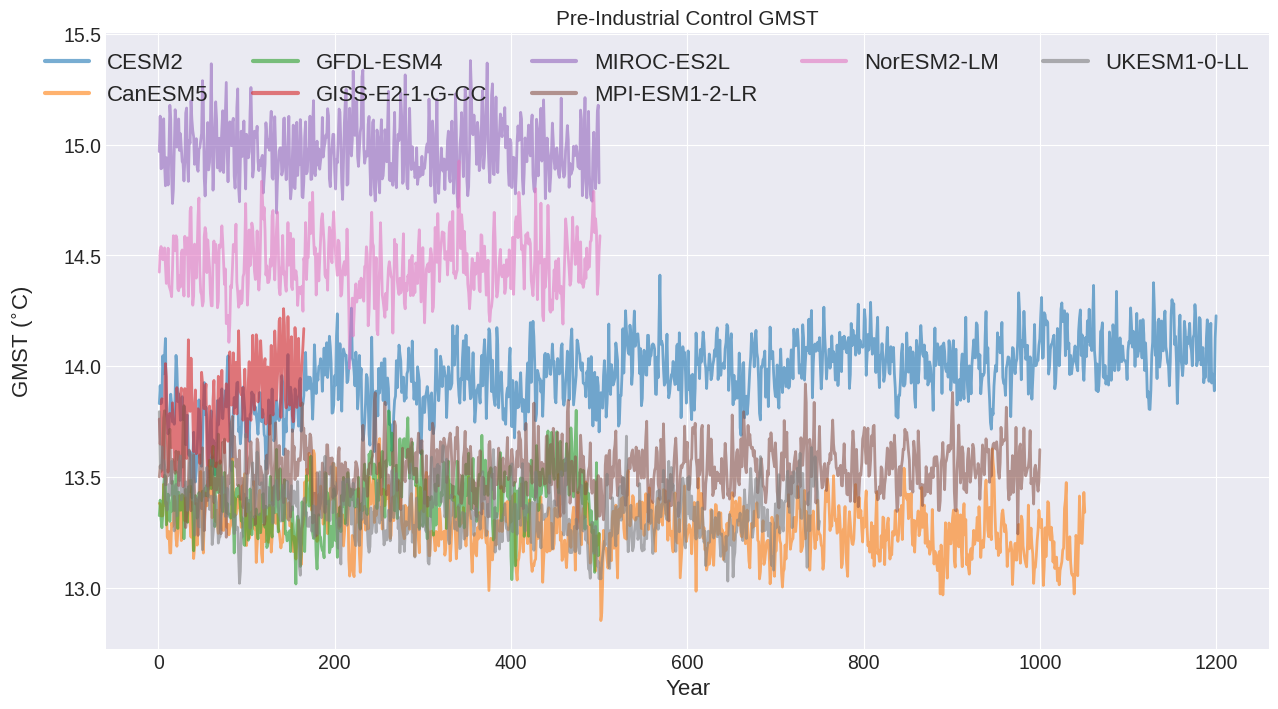

In [32]:

plt.style.use('seaborn-darkgrid')
fig, ax = plt.subplots(figsize=(15,8))

time = control_ds_mean['time'].values
years = [t.year for t in time]
for model in list(control_ds_mean.model.values):

    plot_kwargs = dict(alpha = 0.6,linewidth = 2)
        
    ax.plot(years, control_ds_mean.sel(model=model).values - 273.15, label=model, **plot_kwargs)
    
ax.set_ylabel(r'GMST ($^{\circ}$C)', size=16, labelpad=20)
ax.set_xlabel('Year', size=16)
# ax.set_xlim(years[0], years[500])
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(axis='x', labelsize=14)
leg = ax.legend(ncol = 5, fontsize=16)
[line.set_linewidth(3) for line in leg.get_lines()];
ax.set_title('Pre-Industrial Control GMST', fontsize=15);

fig.savefig(os.path.join(constants.IMAGE_SAVE_DIR_TOP_LEVEL, 'zec_03__multi_model_picontrol.png'), bbox_inches='tight')

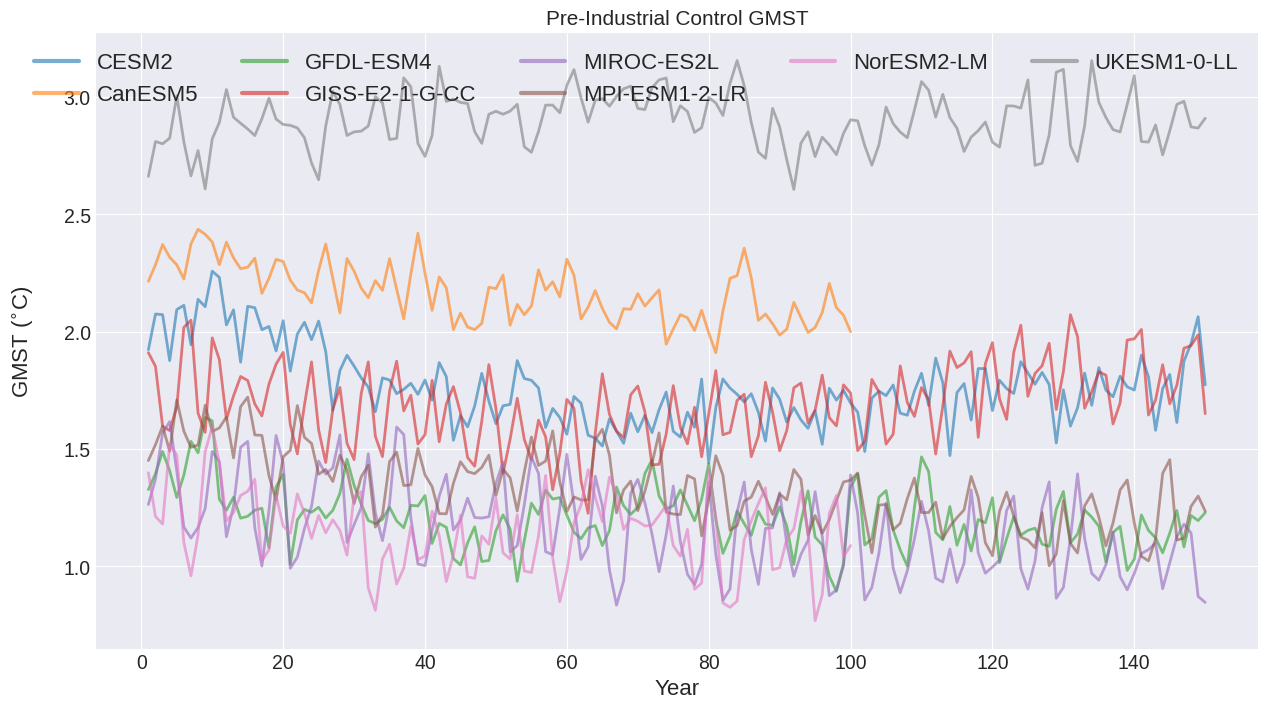

In [34]:

plt.style.use('seaborn-darkgrid')
fig, ax = plt.subplots(figsize=(15,8))

time = experiment_smean_ds['time'].values
years = [t.year for t in time]
for model in list(experiment_smean_ds.model.values):

    plot_kwargs = dict(alpha = 0.6,linewidth = 2)
        
    ax.plot(years, experiment_smean_ds.sel(model=model).tas.values, label=model, **plot_kwargs)
    
ax.set_ylabel(r'GMST ($^{\circ}$C)', size=16, labelpad=20)
ax.set_xlabel('Year', size=16)
# ax.set_xlim(years[0], years[500])
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(axis='x', labelsize=14)
leg = ax.legend(ncol = 5, fontsize=16)
[line.set_linewidth(3) for line in leg.get_lines()];
ax.set_title('Pre-Industrial Control GMST', fontsize=15);

fig.savefig(os.path.join(constants.IMAGE_SAVE_DIR_TOP_LEVEL, 'zec_03_multi_model_experiment.png'), 
            bbox_inches='tight')